In [1]:
# for schema in ['football_games','labels','features']:
#     os.mkdir(schema)
#     for tbl in spark.sql(f'SHOW TABLES in {schema}').toPandas()\
#                 [['database','tableName']].apply(lambda x: '.'.join(x), axis=1)\
#                 .values:
#         print(tbl)
#         spark.sql(f'SELECT * FROM {tbl}').toPandas().to_csv(
#                         '{}/{}.csv'.format(*tbl.split('.')), index=False
#                     )

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../config/initialize_nospark.ipynb

import pickle as pickle
import json

In [3]:
sys.path.append('../../config')
from mpl_style import *

rcParams['figure.dpi'] = 96
rcParams['figure.figsize'] = (12,8)

In [4]:
import matplotlib as mpl
params_backup = rcParams.copy()

In [5]:
import sys 
os.chdir(
    '/Users/joshplotkin/Dropbox/data_science/modeling-football-outcomes/'
)
sys.path.append('04_model_pipeline_dev/')
from json_validator import validate_model_json, validate_eval_json
from CVData import CVData
from TrainAndScoreModel import TrainAndScoreModel
from EvaluateModel import EvaluationData, EvaluateAndPlot
from Stopwatch import Stopwatch

In [6]:
stopwatch = Stopwatch()

## Load and validate JSON files

In [9]:
model_dict = json.load(open('04_model_pipeline_dev/model.json','r'))
validate_model_json(model_dict)

plots_dict = json.load(open('04_model_pipeline_dev/evaluate.json','r'))
validate_eval_json(model_dict, plots_dict)
stopwatch.add('loaded and validated')

Model JSON configuration files passed checks.
Eval dict configuration files passed checks.


## Start executing

### Generate CV Sets

In [10]:
cv = CVData(model_dict)
model_data = cv.generate_cv_data()
is_classification = cv.is_classification
stopwatch.add('made CV sets')

In [11]:
# model_data['training'].groupby(['season','fold'])\
#     .size()\
#     .reset_index()\
#     .pivot(index='season', columns='fold', values=0)\
#     .fillna(0)

### Train/Score

In [12]:
model = TrainAndScoreModel(model_dict, is_classification)
model.cv_train_and_score(model_data['training'], 
               model_data['scoring_only'])
stopwatch.add('trained and scores')

##### Score holdout

In [13]:
holdout = model.score_holdout(model.model_objects['full'], 
                               model_data['holdout'])

### Method 1: Easy Plot All

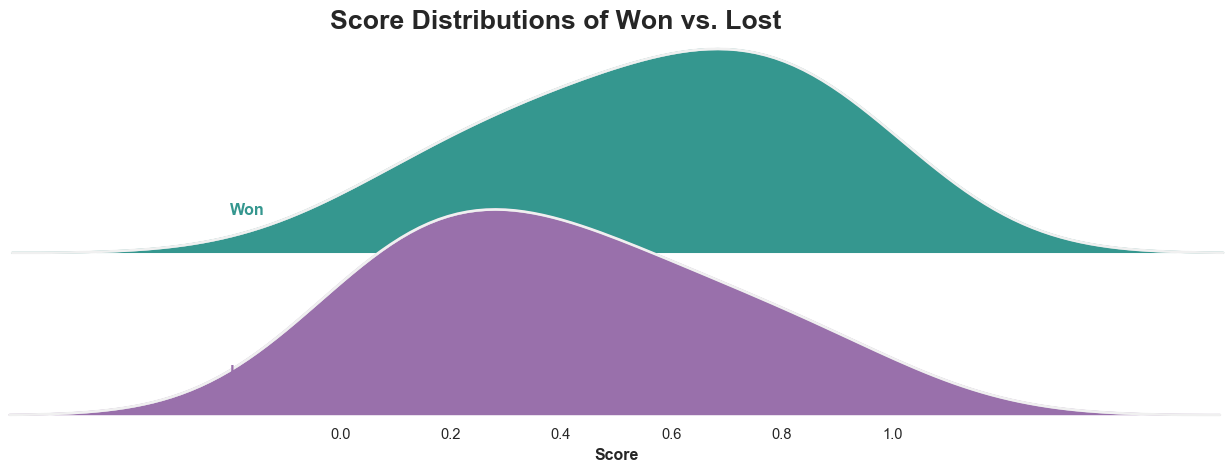

<Figure size 1152x768 with 0 Axes>

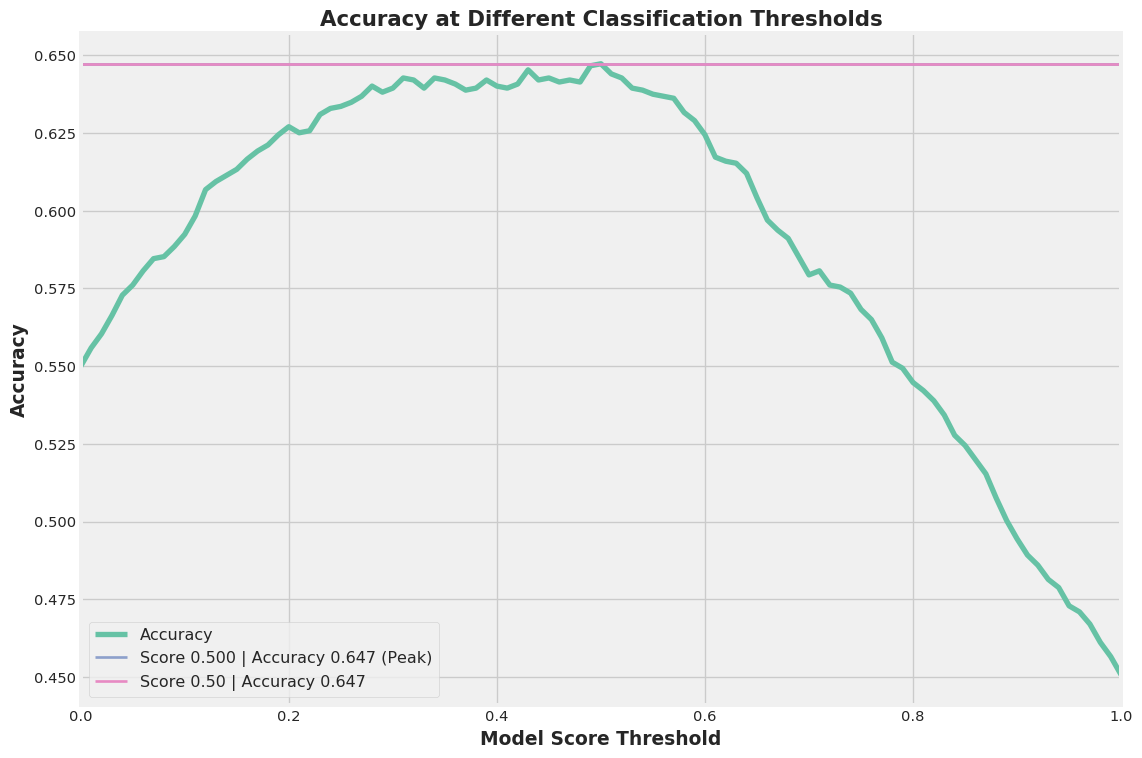

<Figure size 1152x768 with 0 Axes>

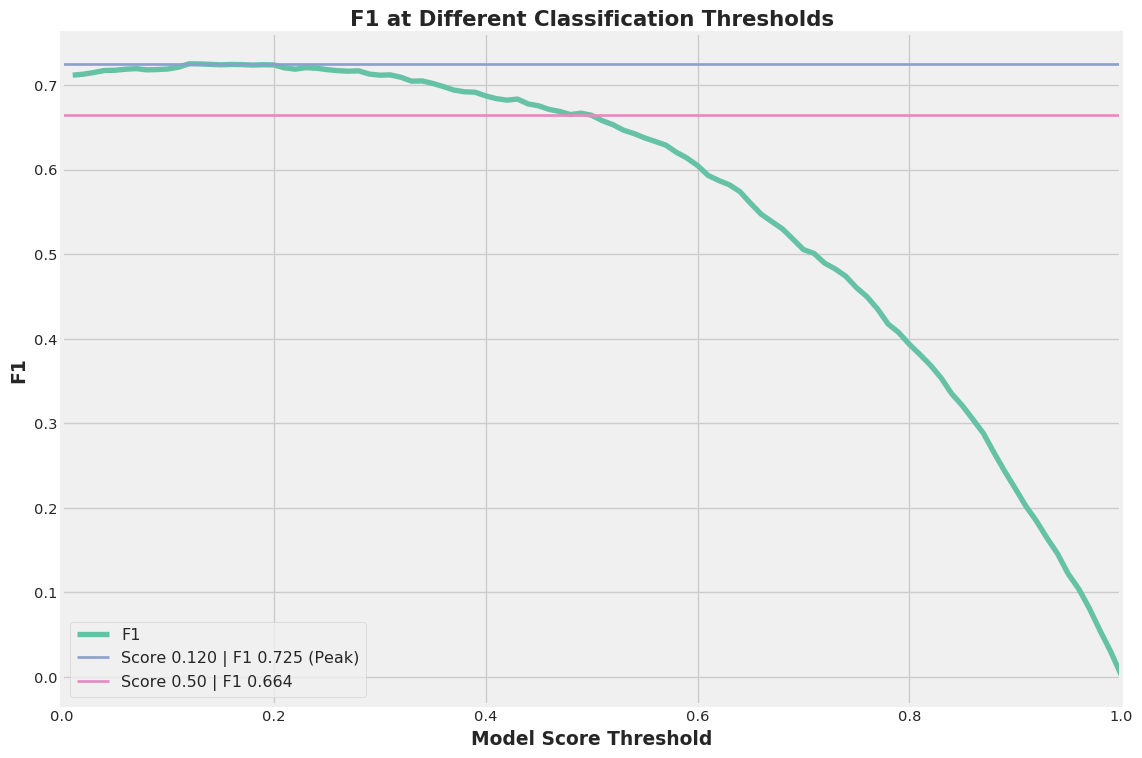

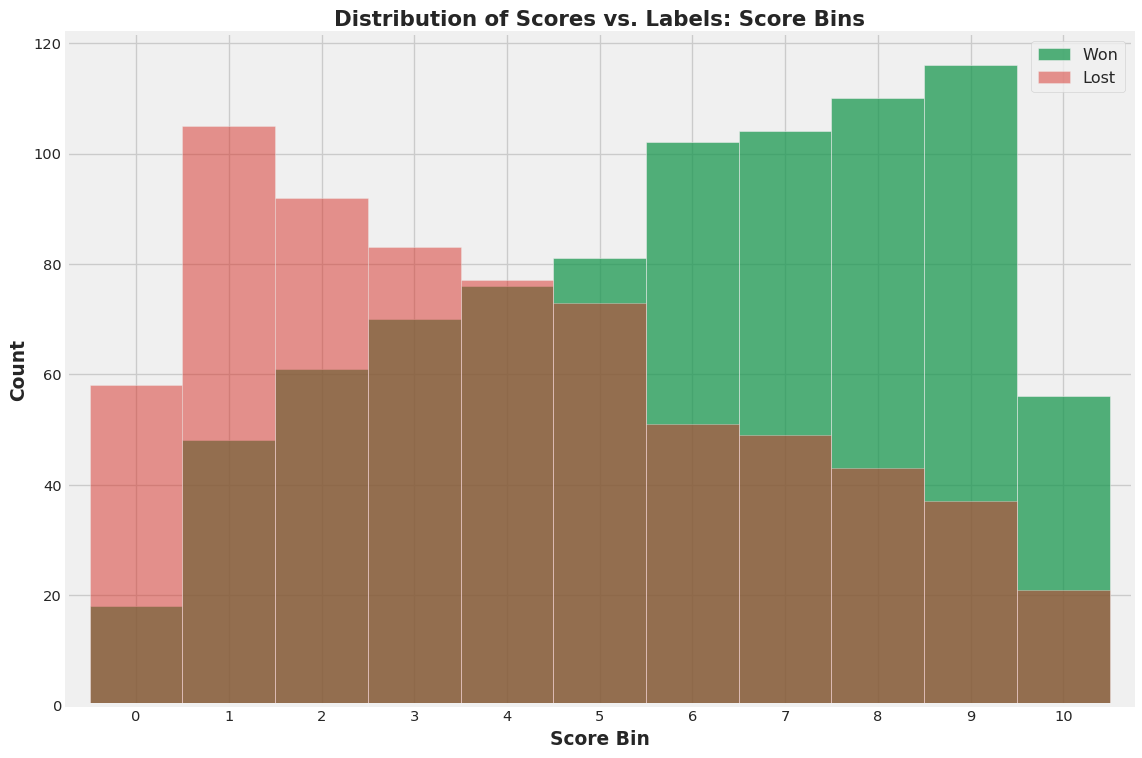

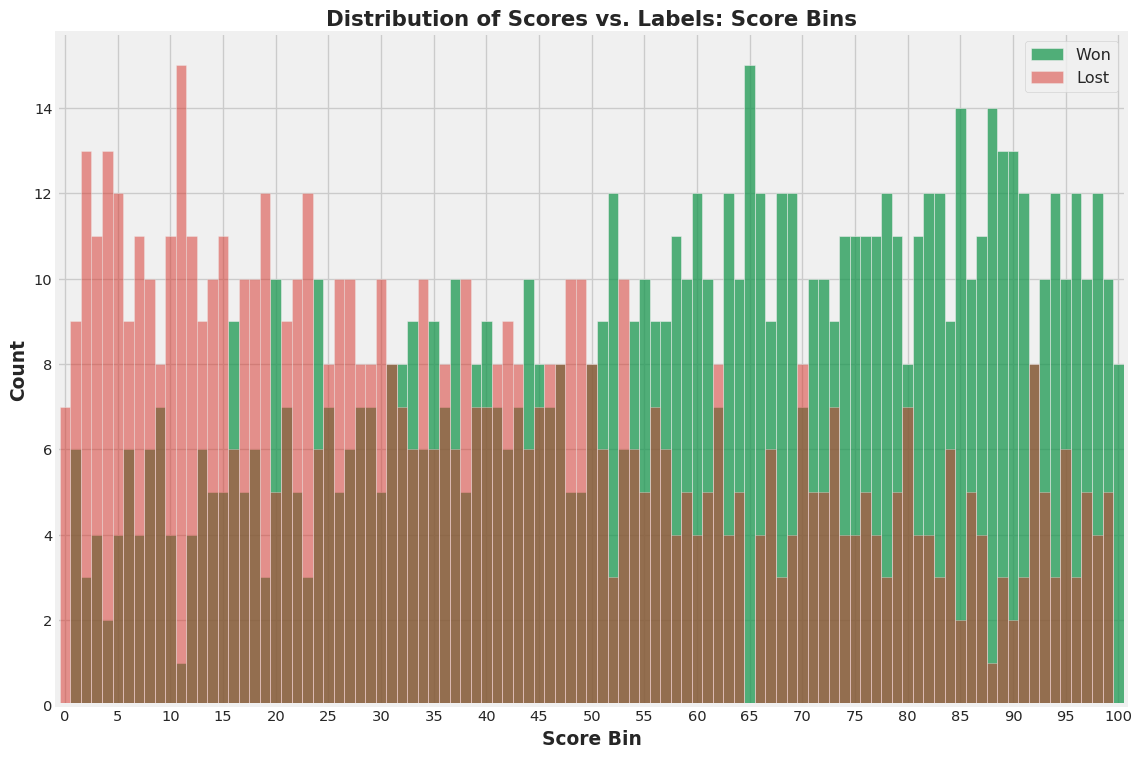

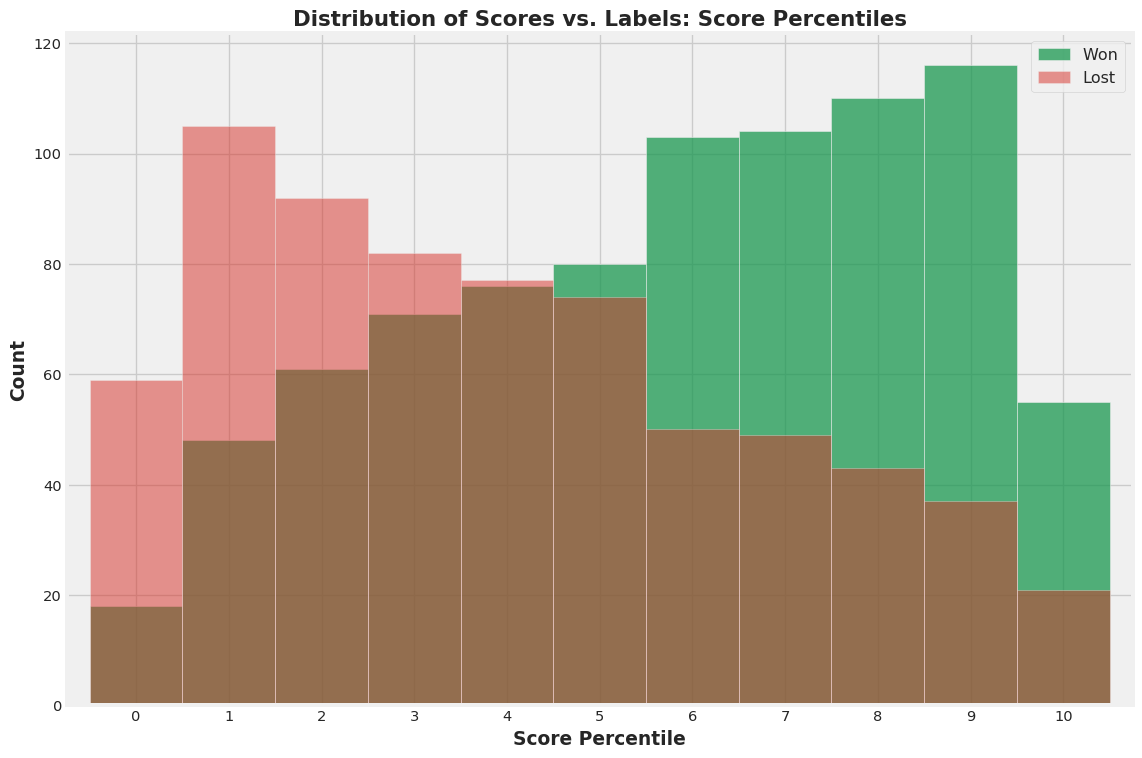

<Figure size 1152x768 with 0 Axes>

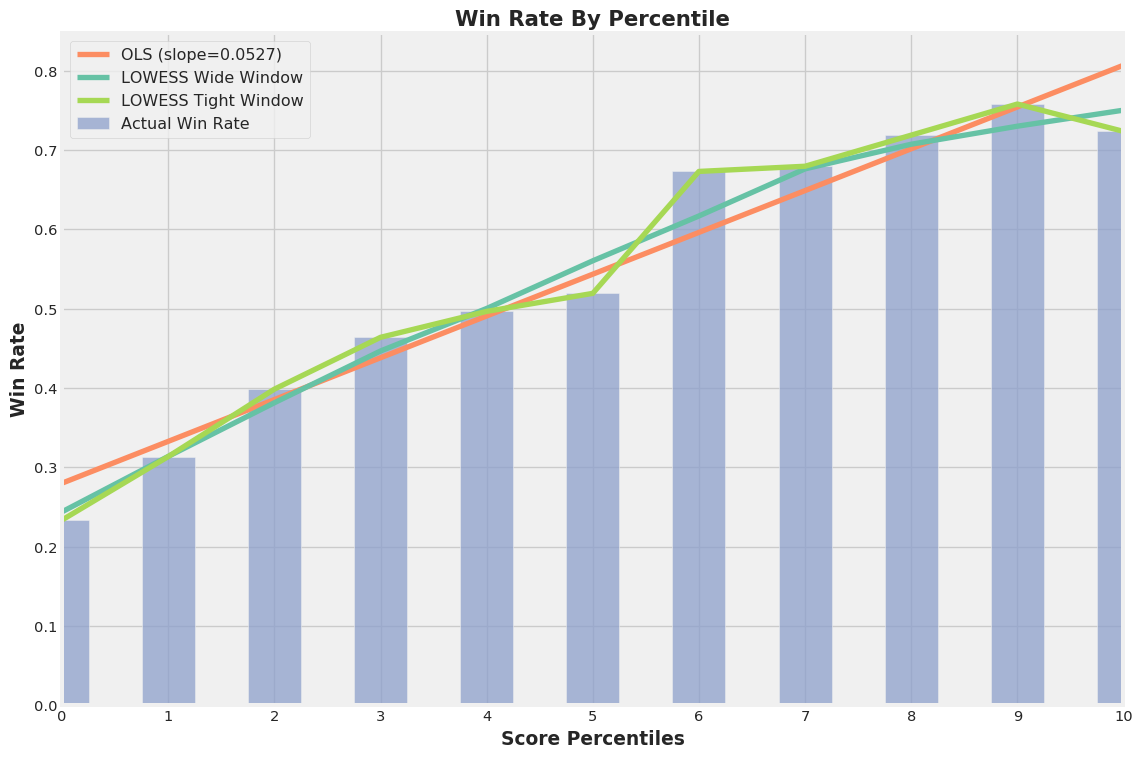

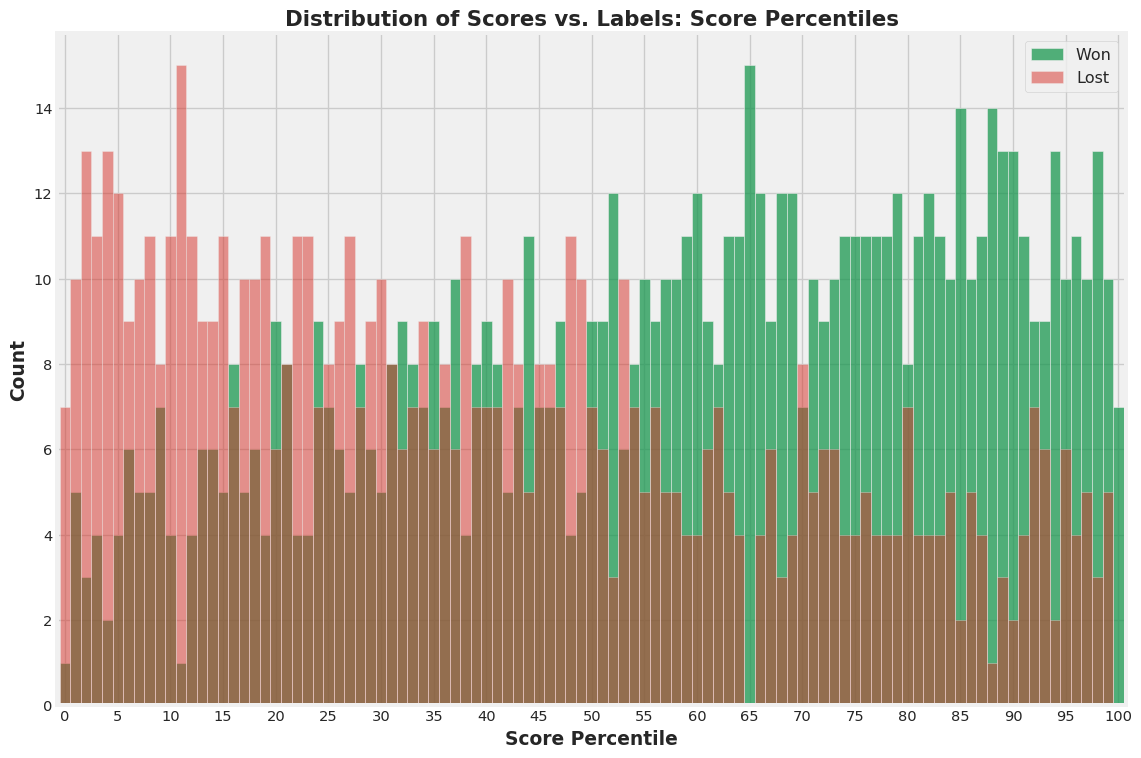

<Figure size 1152x768 with 0 Axes>

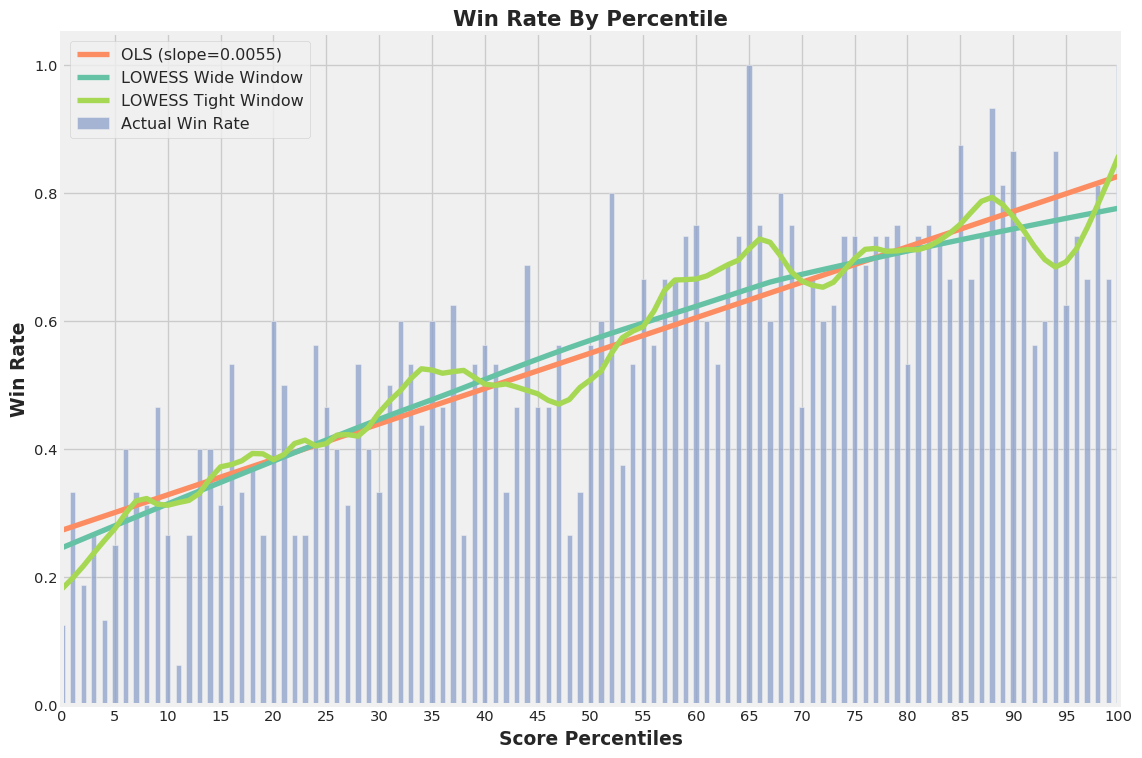

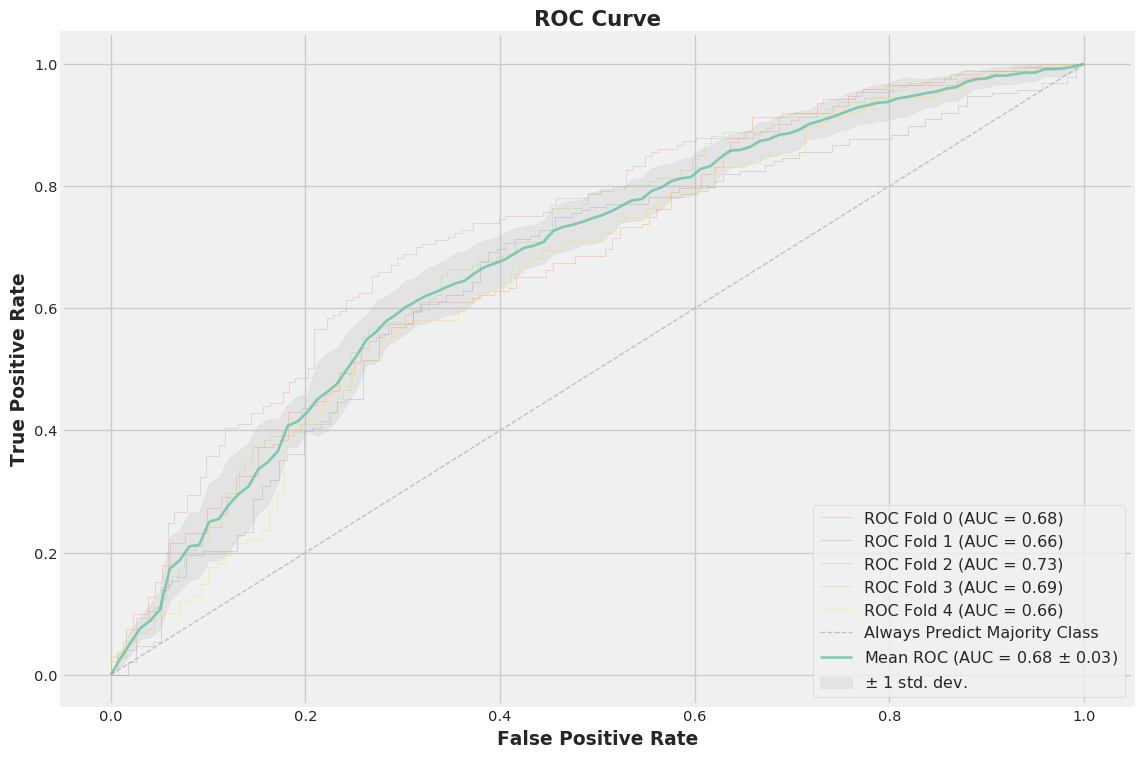

<Figure size 1152x768 with 0 Axes>

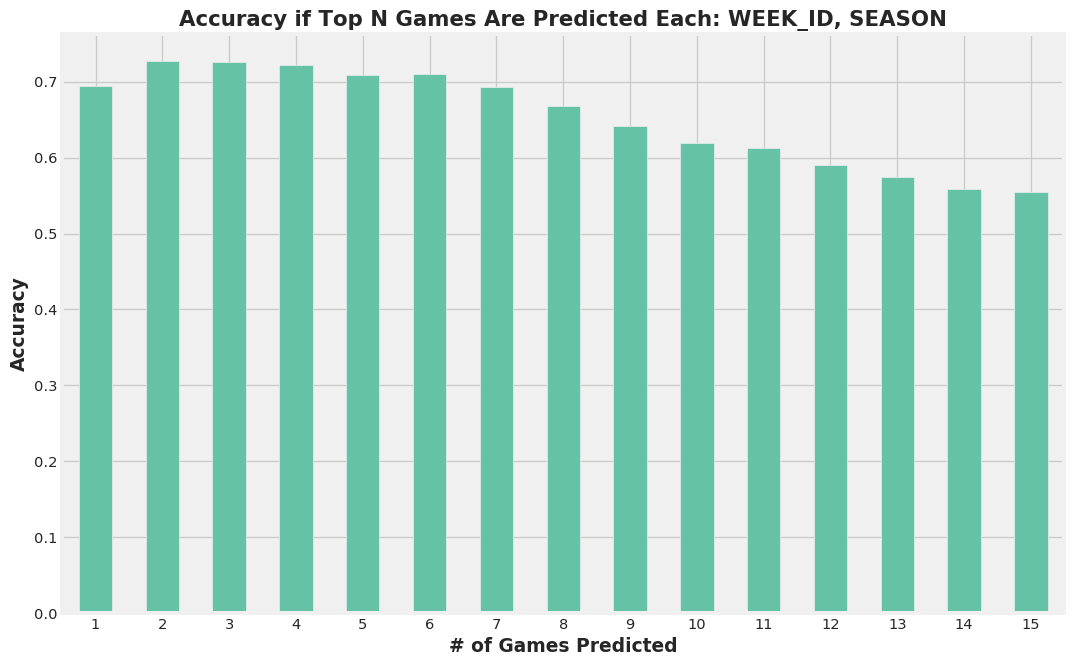

<Figure size 1152x768 with 0 Axes>

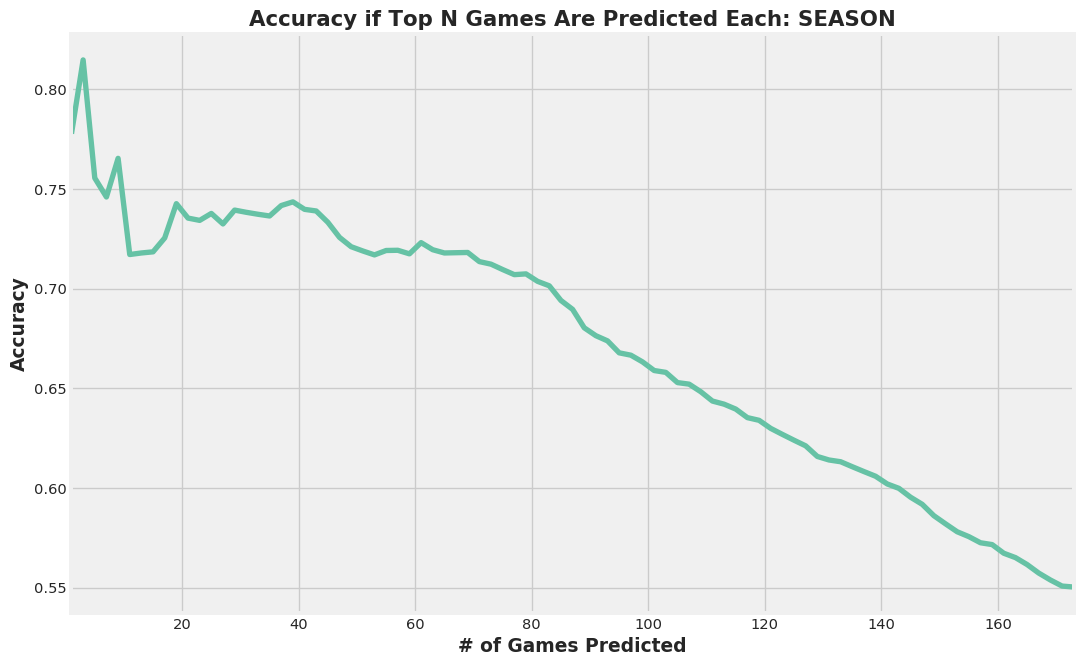

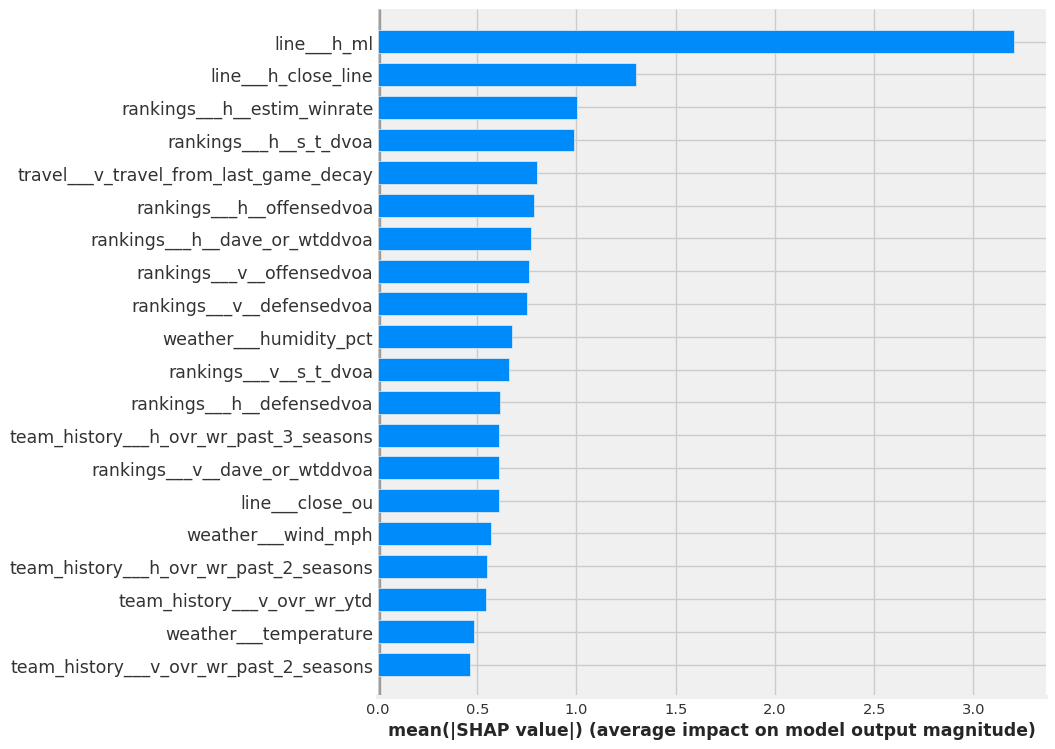

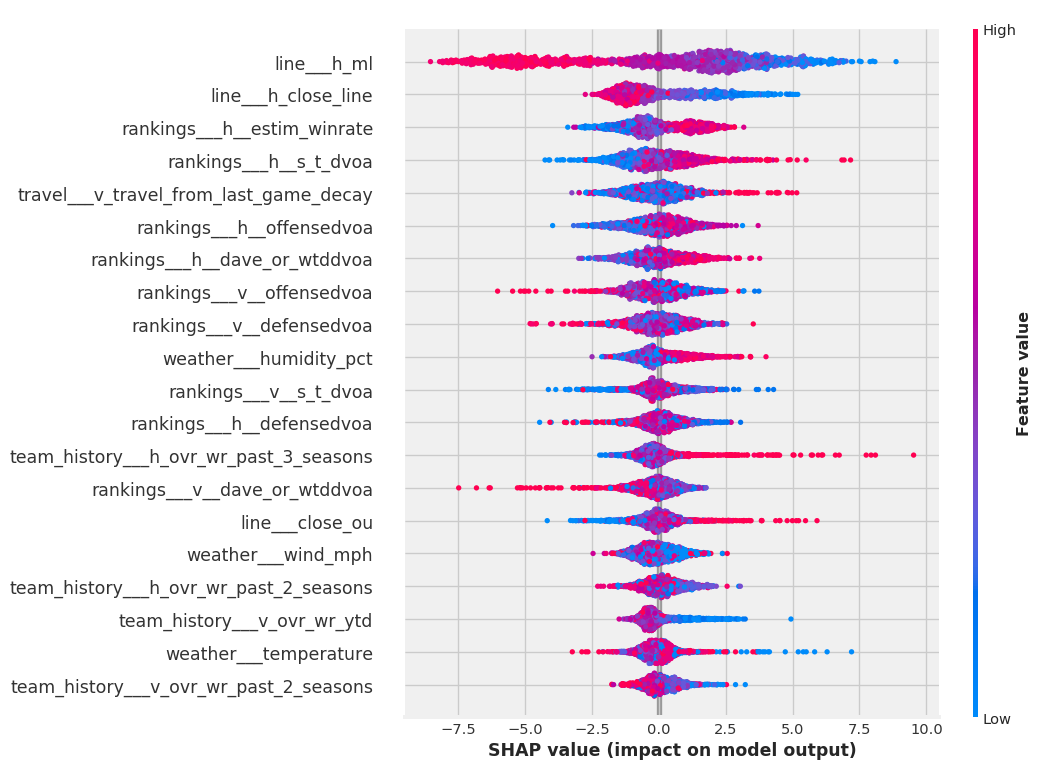

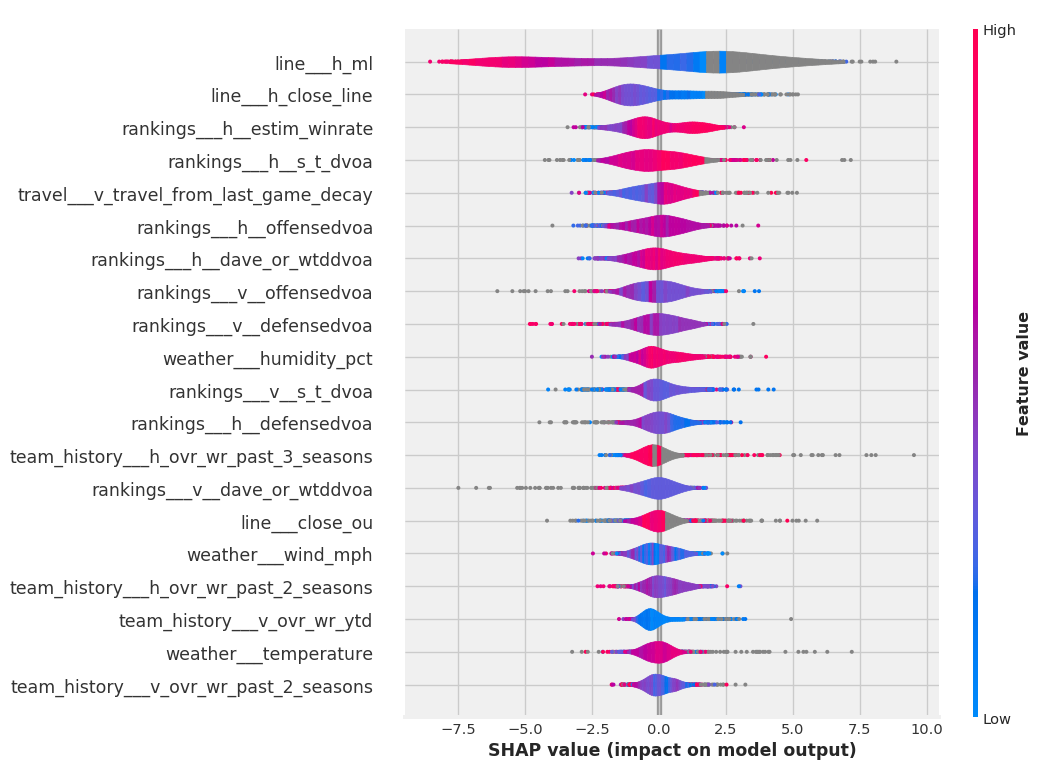

<Figure size 1152x768 with 0 Axes>

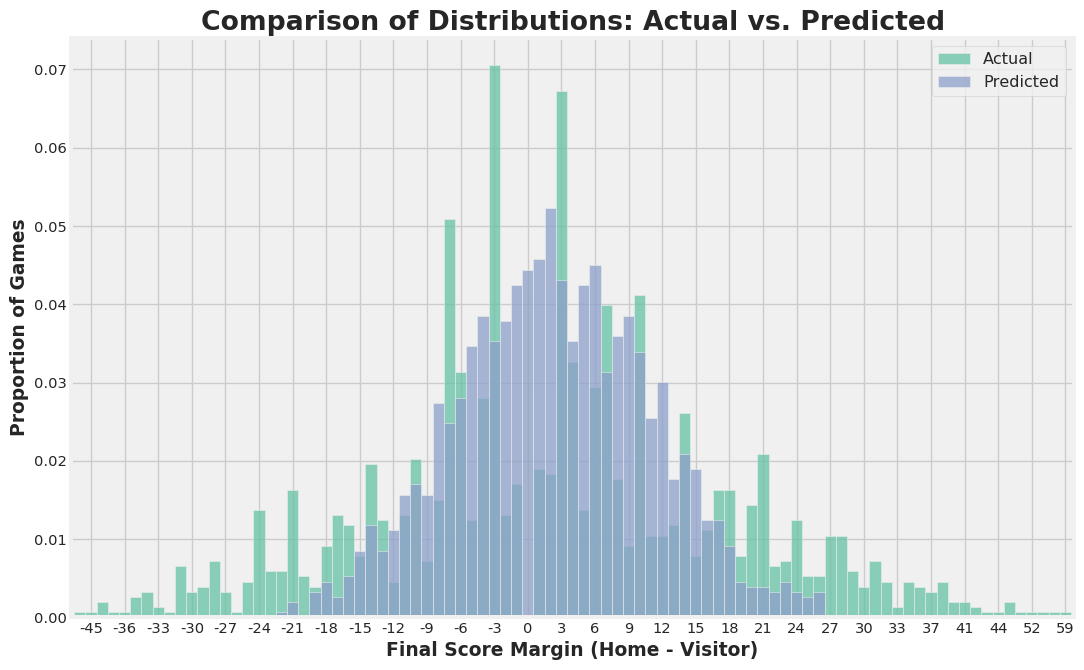

<Figure size 1152x768 with 0 Axes>

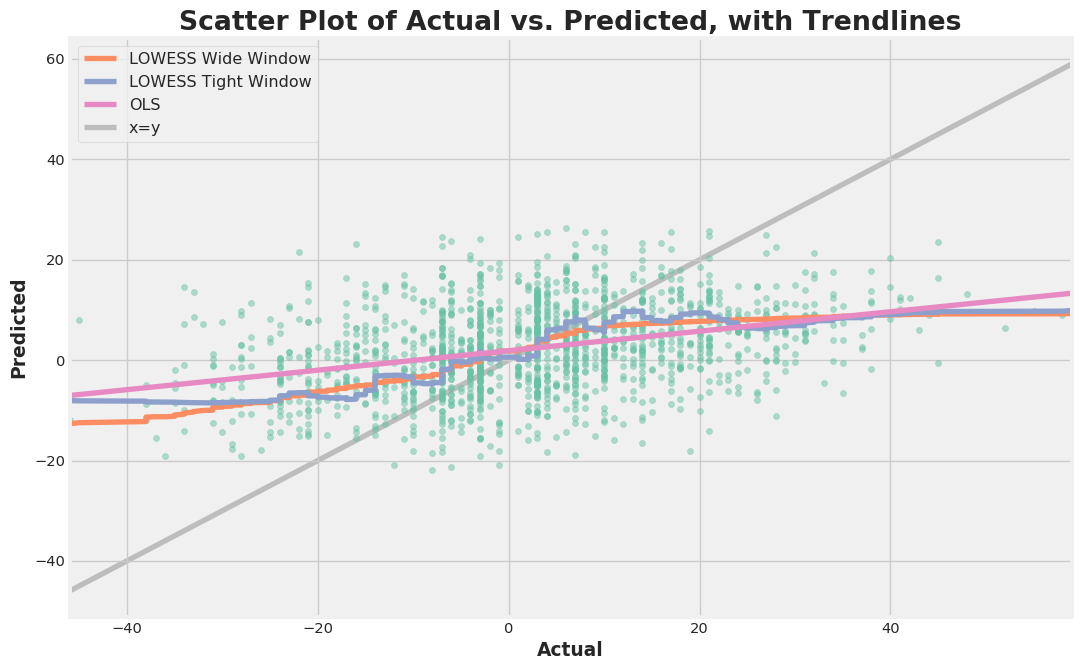

<Figure size 1152x768 with 0 Axes>

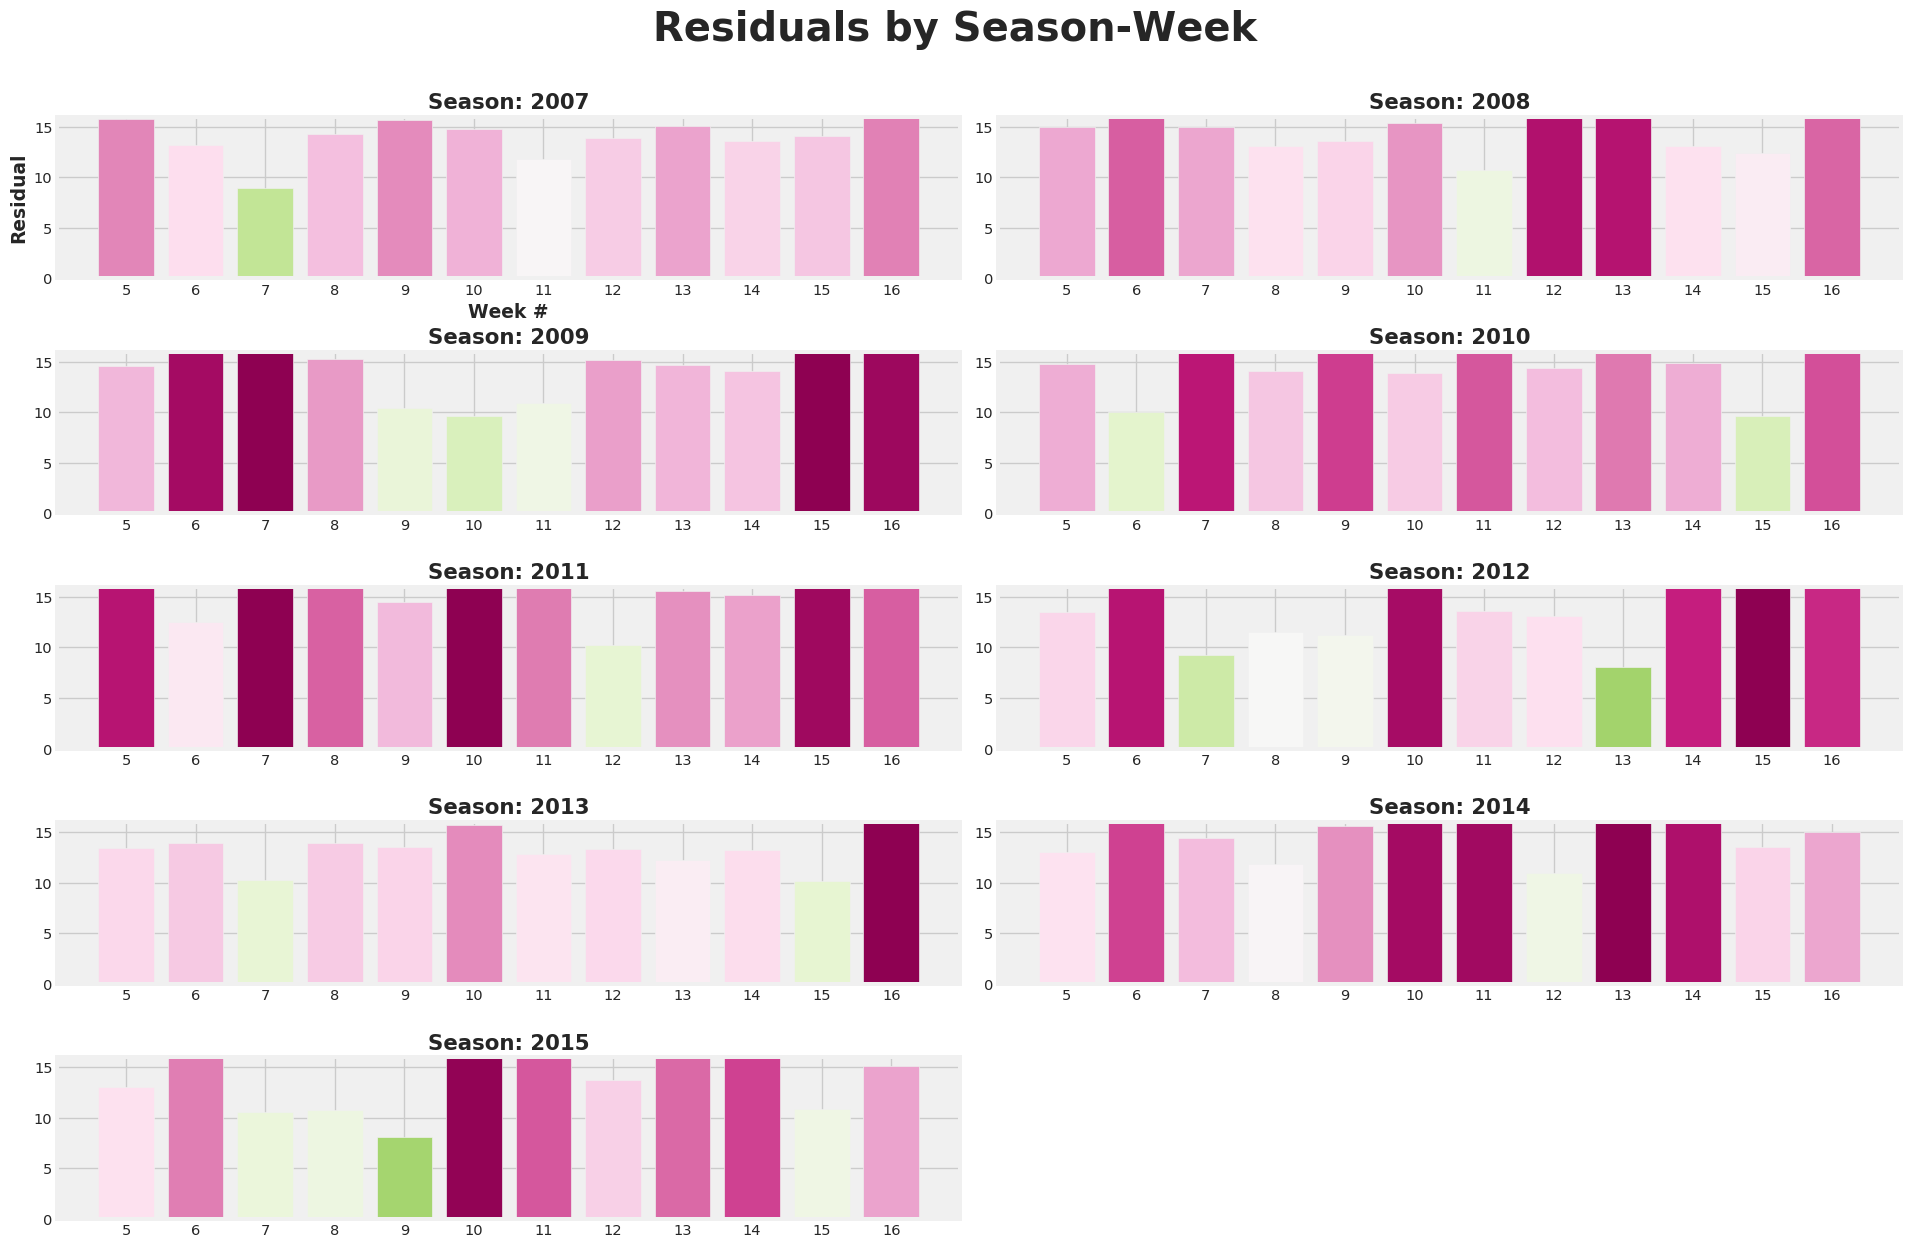

<Figure size 1152x768 with 0 Axes>

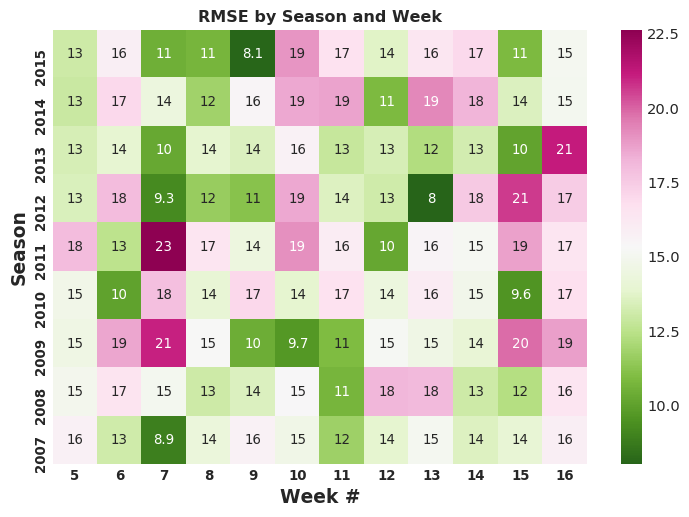

<Figure size 1152x768 with 0 Axes>

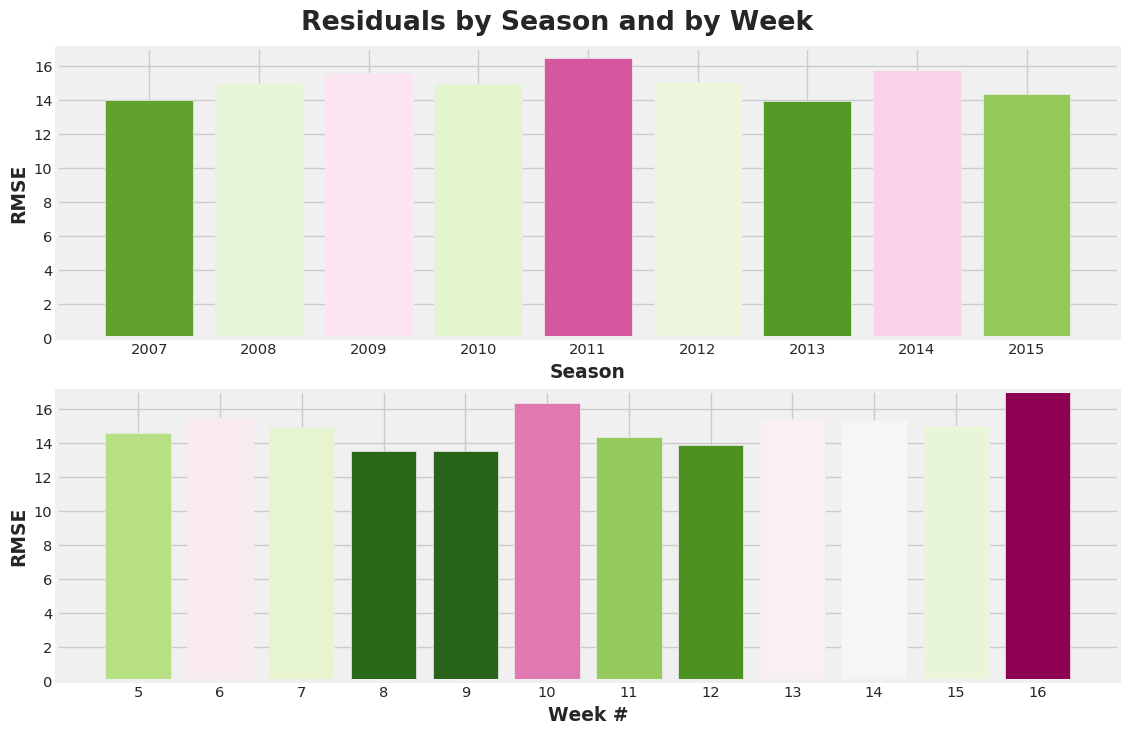

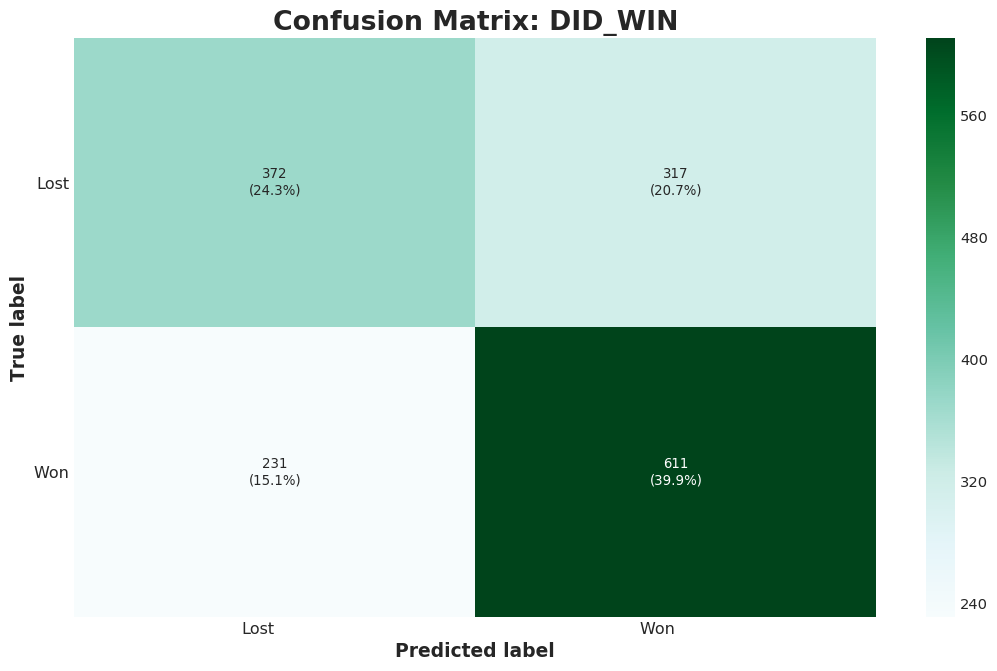

<Figure size 1152x768 with 0 Axes>

<Figure size 2304x2304 with 0 Axes>

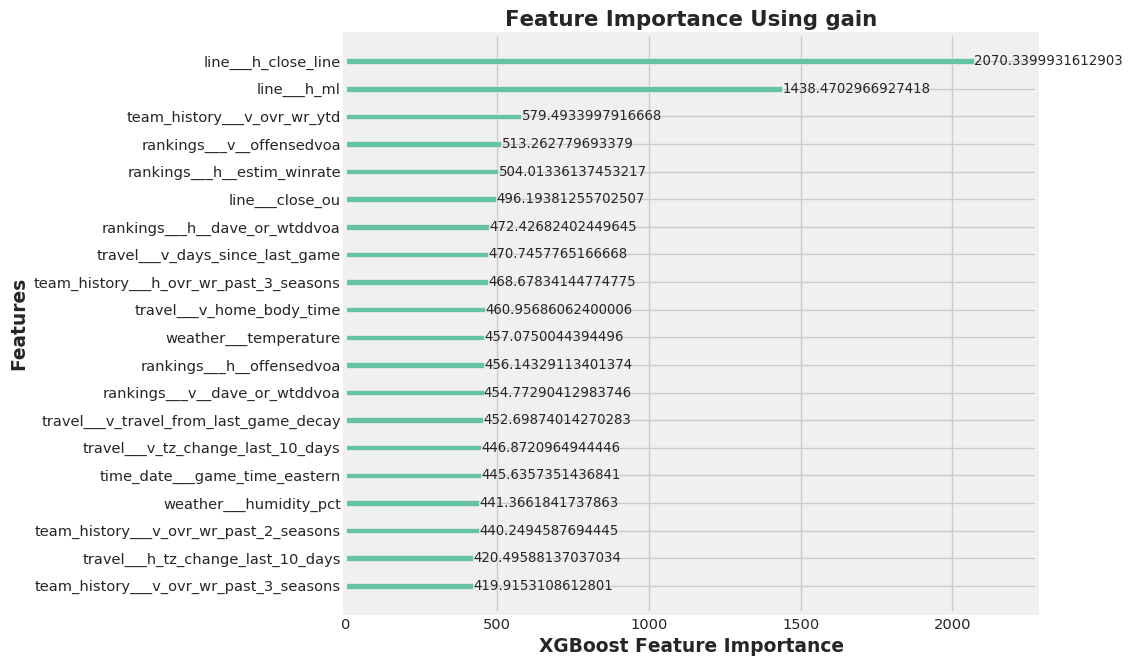

<Figure size 1152x768 with 0 Axes>

In [167]:
plots_dict['save_plots'] = False
plots_dict['save_stats'] = True
plot = EvaluateAndPlot(
    plots_dict, model.cv_scores, model.is_classification
)
    
plot.plot_all(model, model.model_objects['full'])

stopwatch.add('ran plot_all and saved')

### Method 2: Get Data and (optionally) Plots Second

#### Manual Data

In [158]:
evalu = EvaluationData(plots_dict, model.cv_scores)

acc_dfs = {}
for metric in plots_dict['threshold_metrics']:
    acc_dfs[metric] = evalu.get_threshold_data(metric)

ridge_df = evalu.get_ridge_data()

mean_auc = evalu.get_mean_auc()

bins_dfs = {}
for bin_type in plots_dict['bin_types']:
    bins_dfs[bin_type] = {}
    for nbins in plots_dict['plot_bins']:
        bins_dfs[bin_type][nbins] = evalu.get_bins_data(bin_type, nbins)
    
acc_topn = {}
for col_range in plots_dict['accuracy_at_topn'].items():
    acc_topn[col_range[0]] = evalu.get_accuracy_at_topn(*col_range)
    
residuals, mean_residuals, pivot_residuals = plot.get_residuals_season_week_mean()
scatter = plot.get_scatter_data()
vals = plot.get_distributions_data()
confusion_df = plot.get_confusion_matrix_data('label', 'binary_pred')
    
importances = plot.get_feature_importances(model.model_objects['full'])
shap_df = plot.get_shap_vals(model.model_dict, model.model_objects)

stopwatch.add('evaluate: data-only')    

#### Manual plot

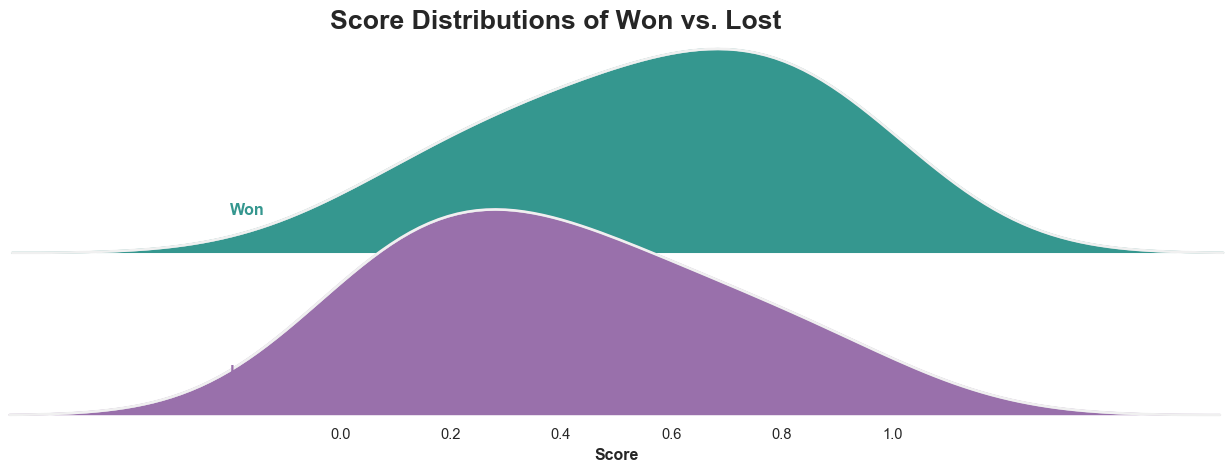

<Figure size 1152x768 with 0 Axes>

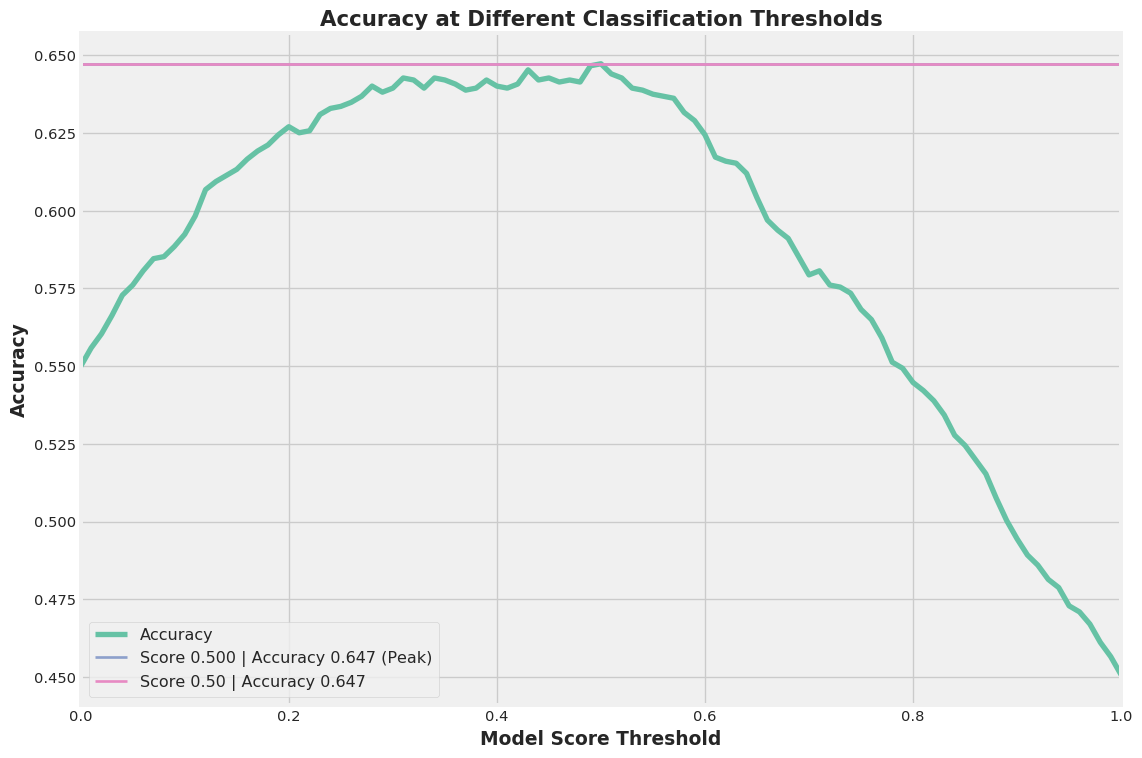

<Figure size 1152x768 with 0 Axes>

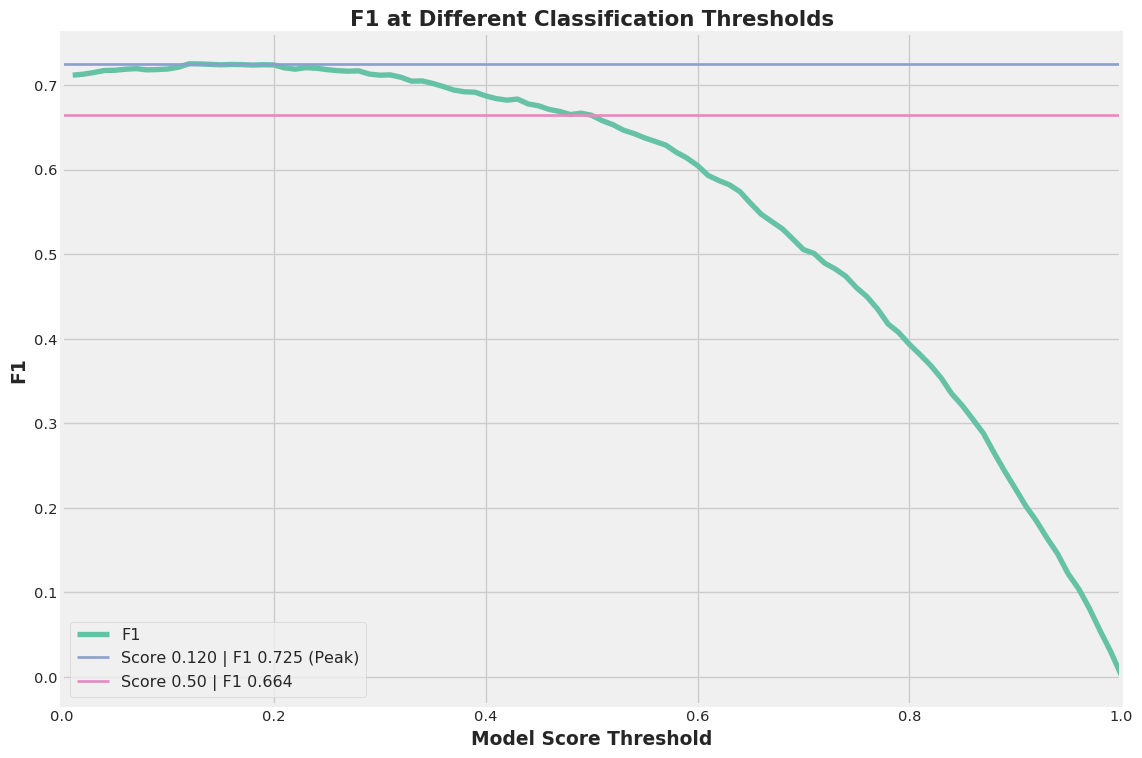

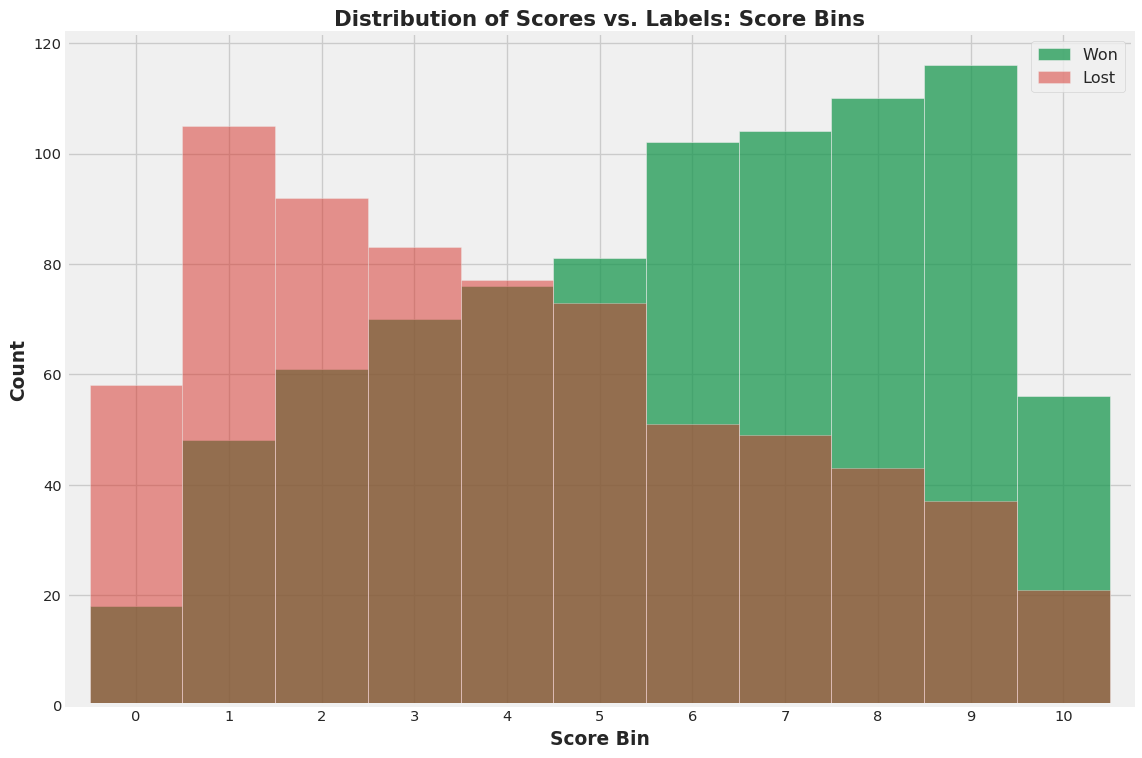

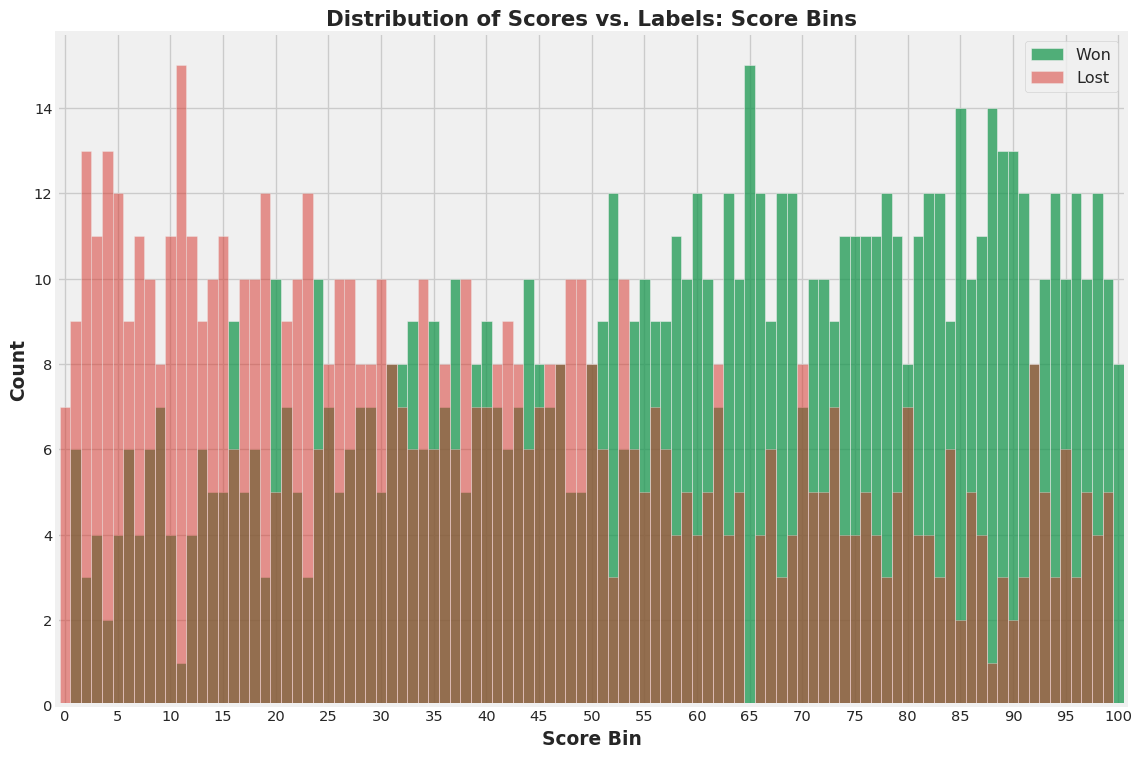

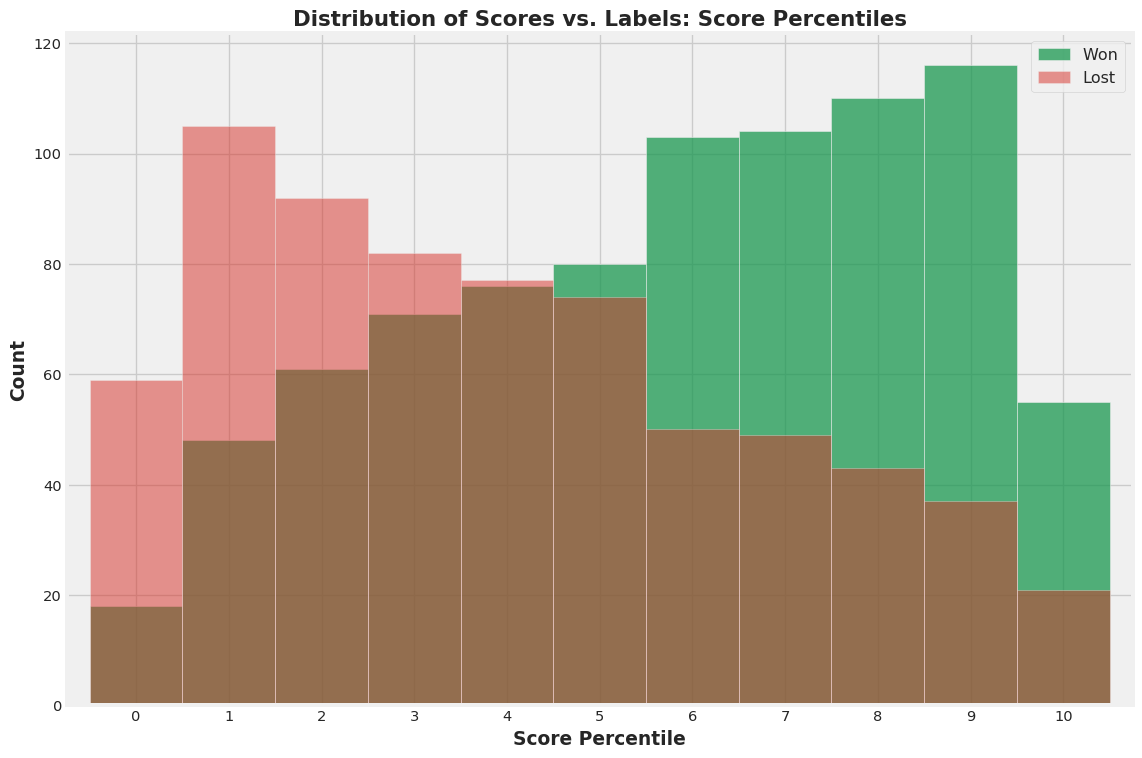

<Figure size 1152x768 with 0 Axes>

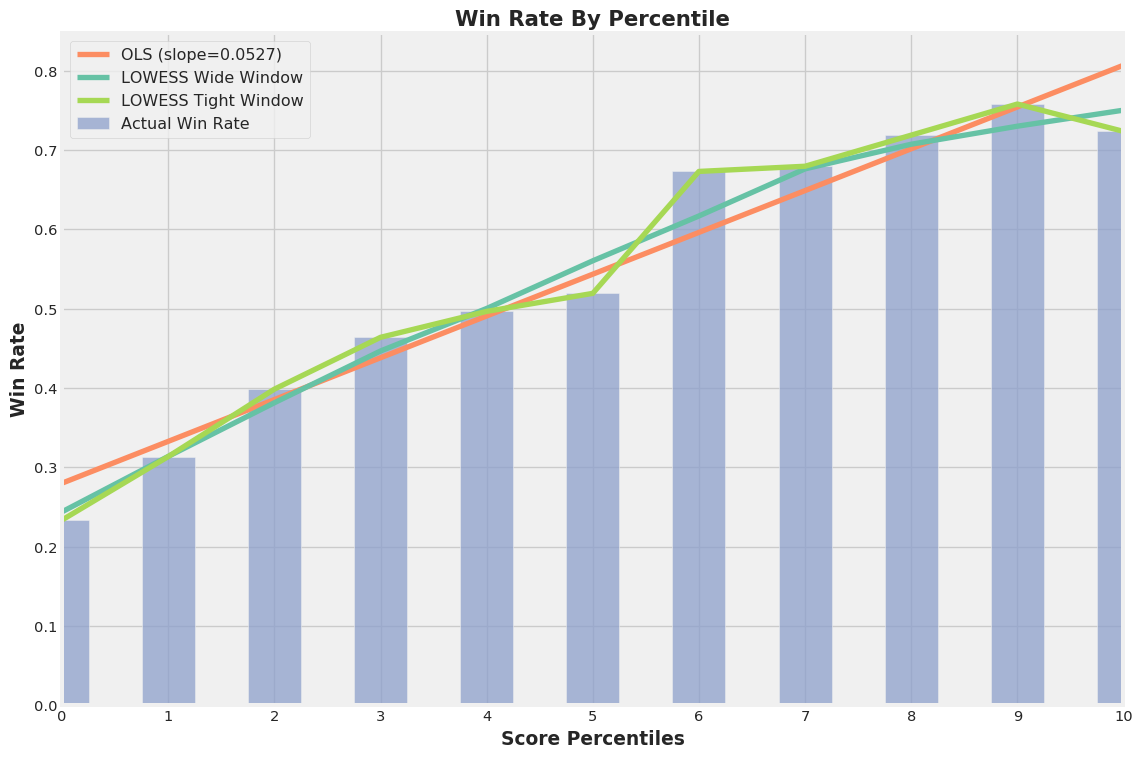

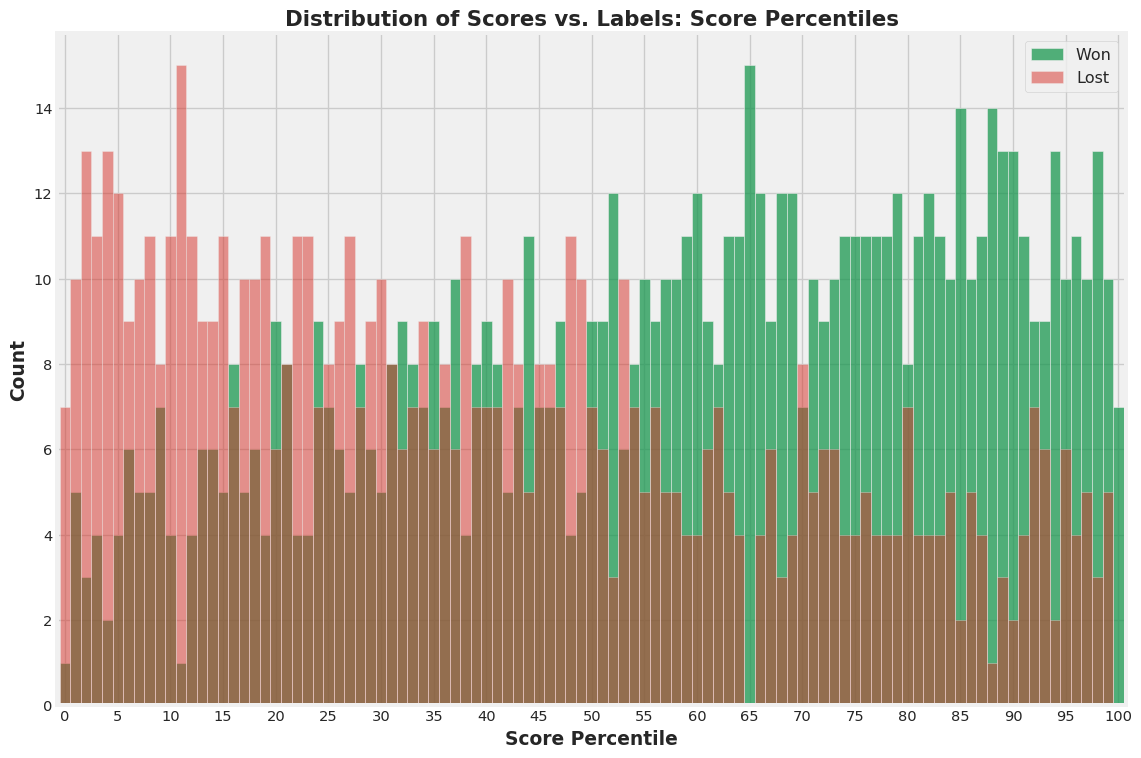

<Figure size 1152x768 with 0 Axes>

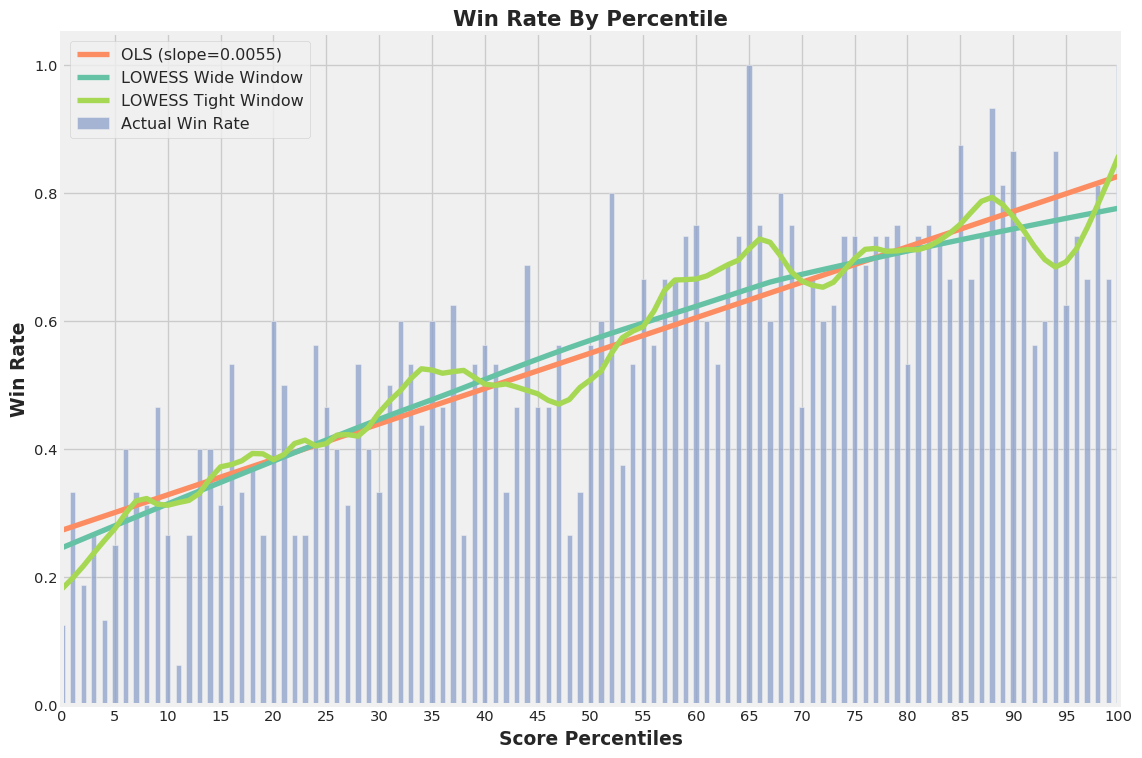

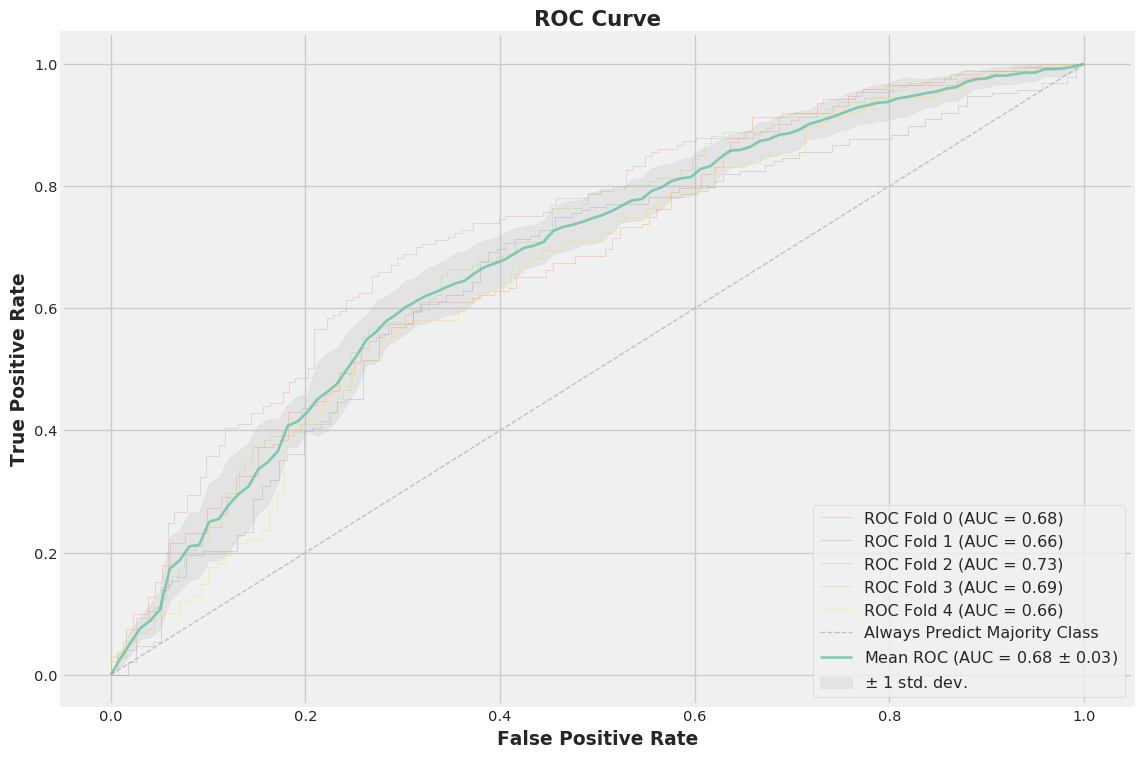

<Figure size 1152x768 with 0 Axes>

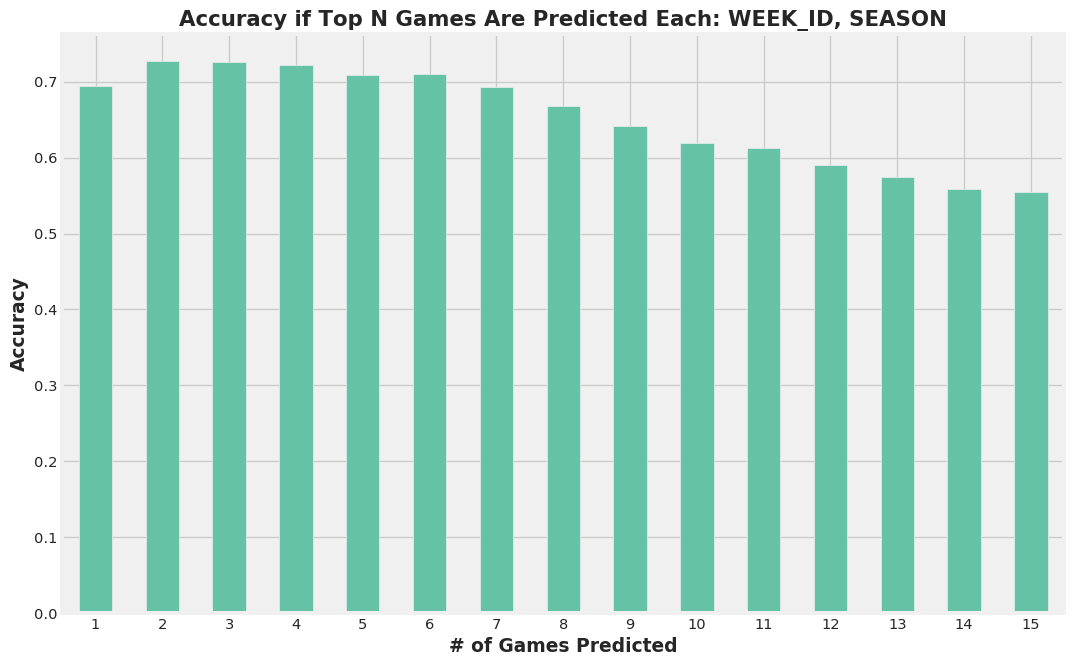

<Figure size 1152x768 with 0 Axes>

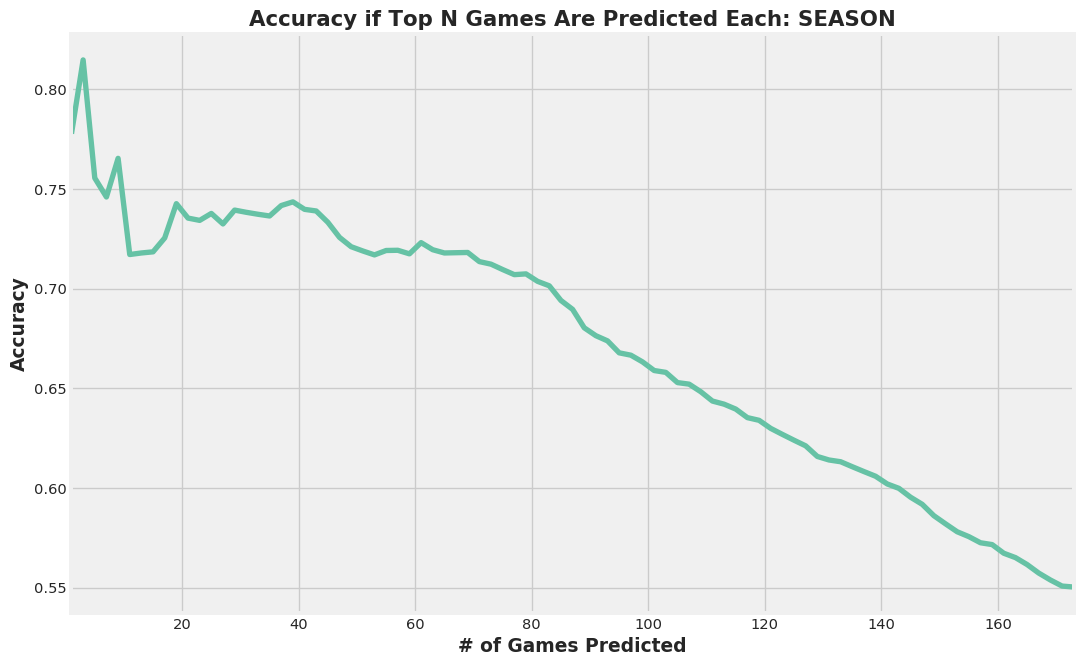

<Figure size 1152x768 with 0 Axes>

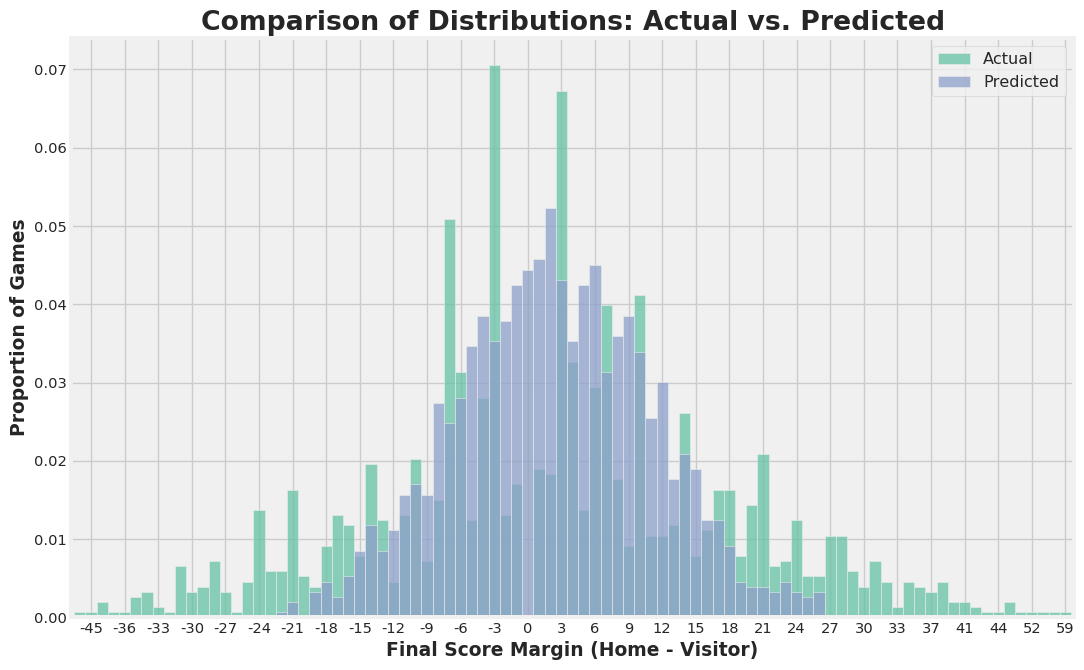

<Figure size 1152x768 with 0 Axes>

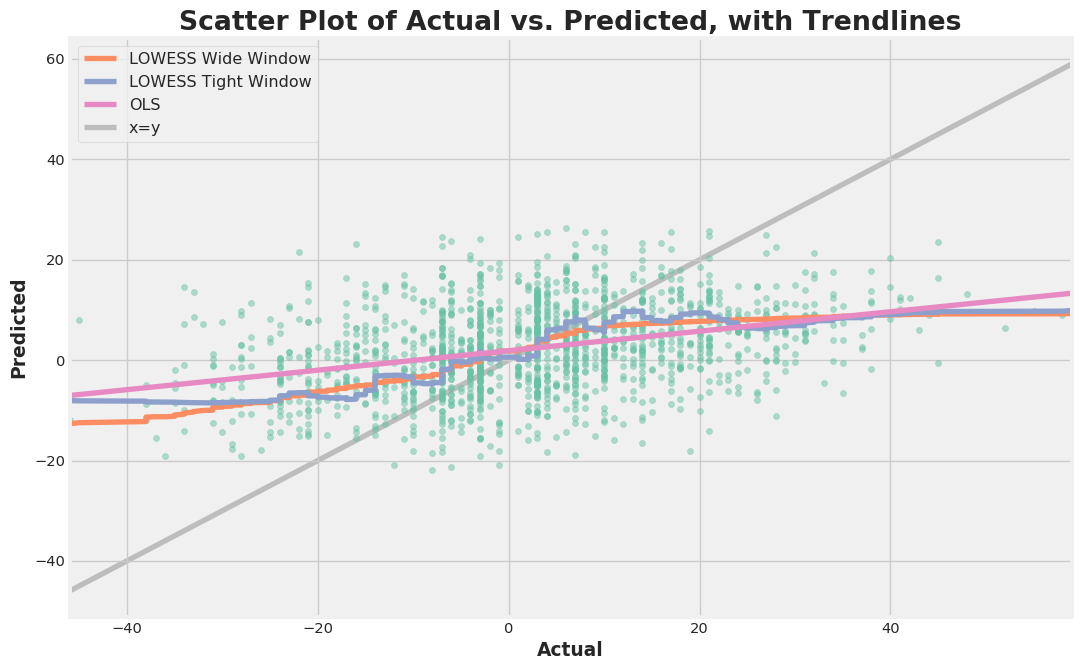

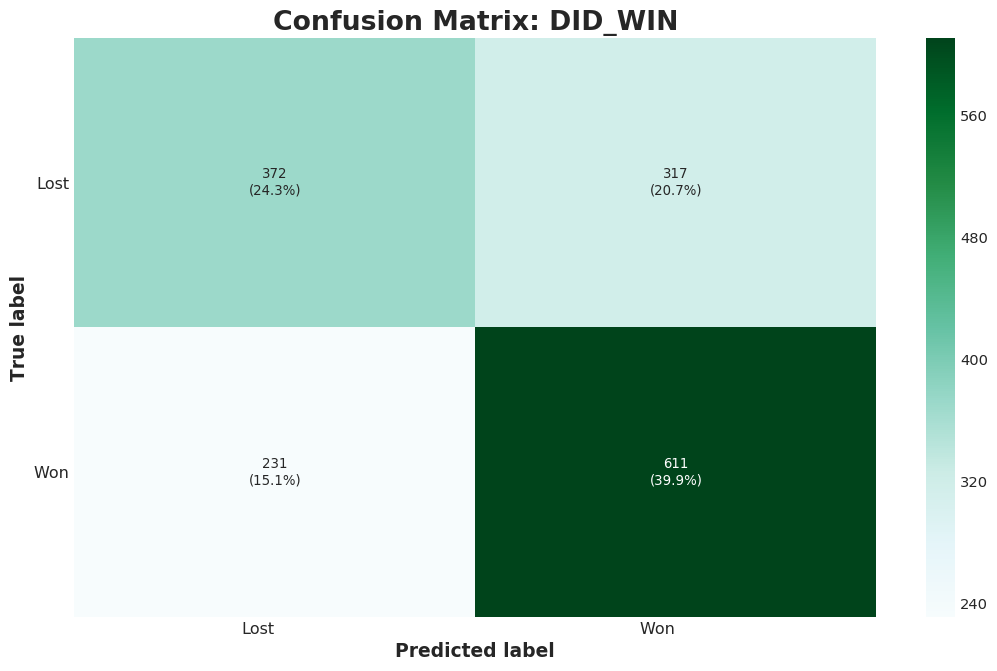

<Figure size 1152x768 with 0 Axes>

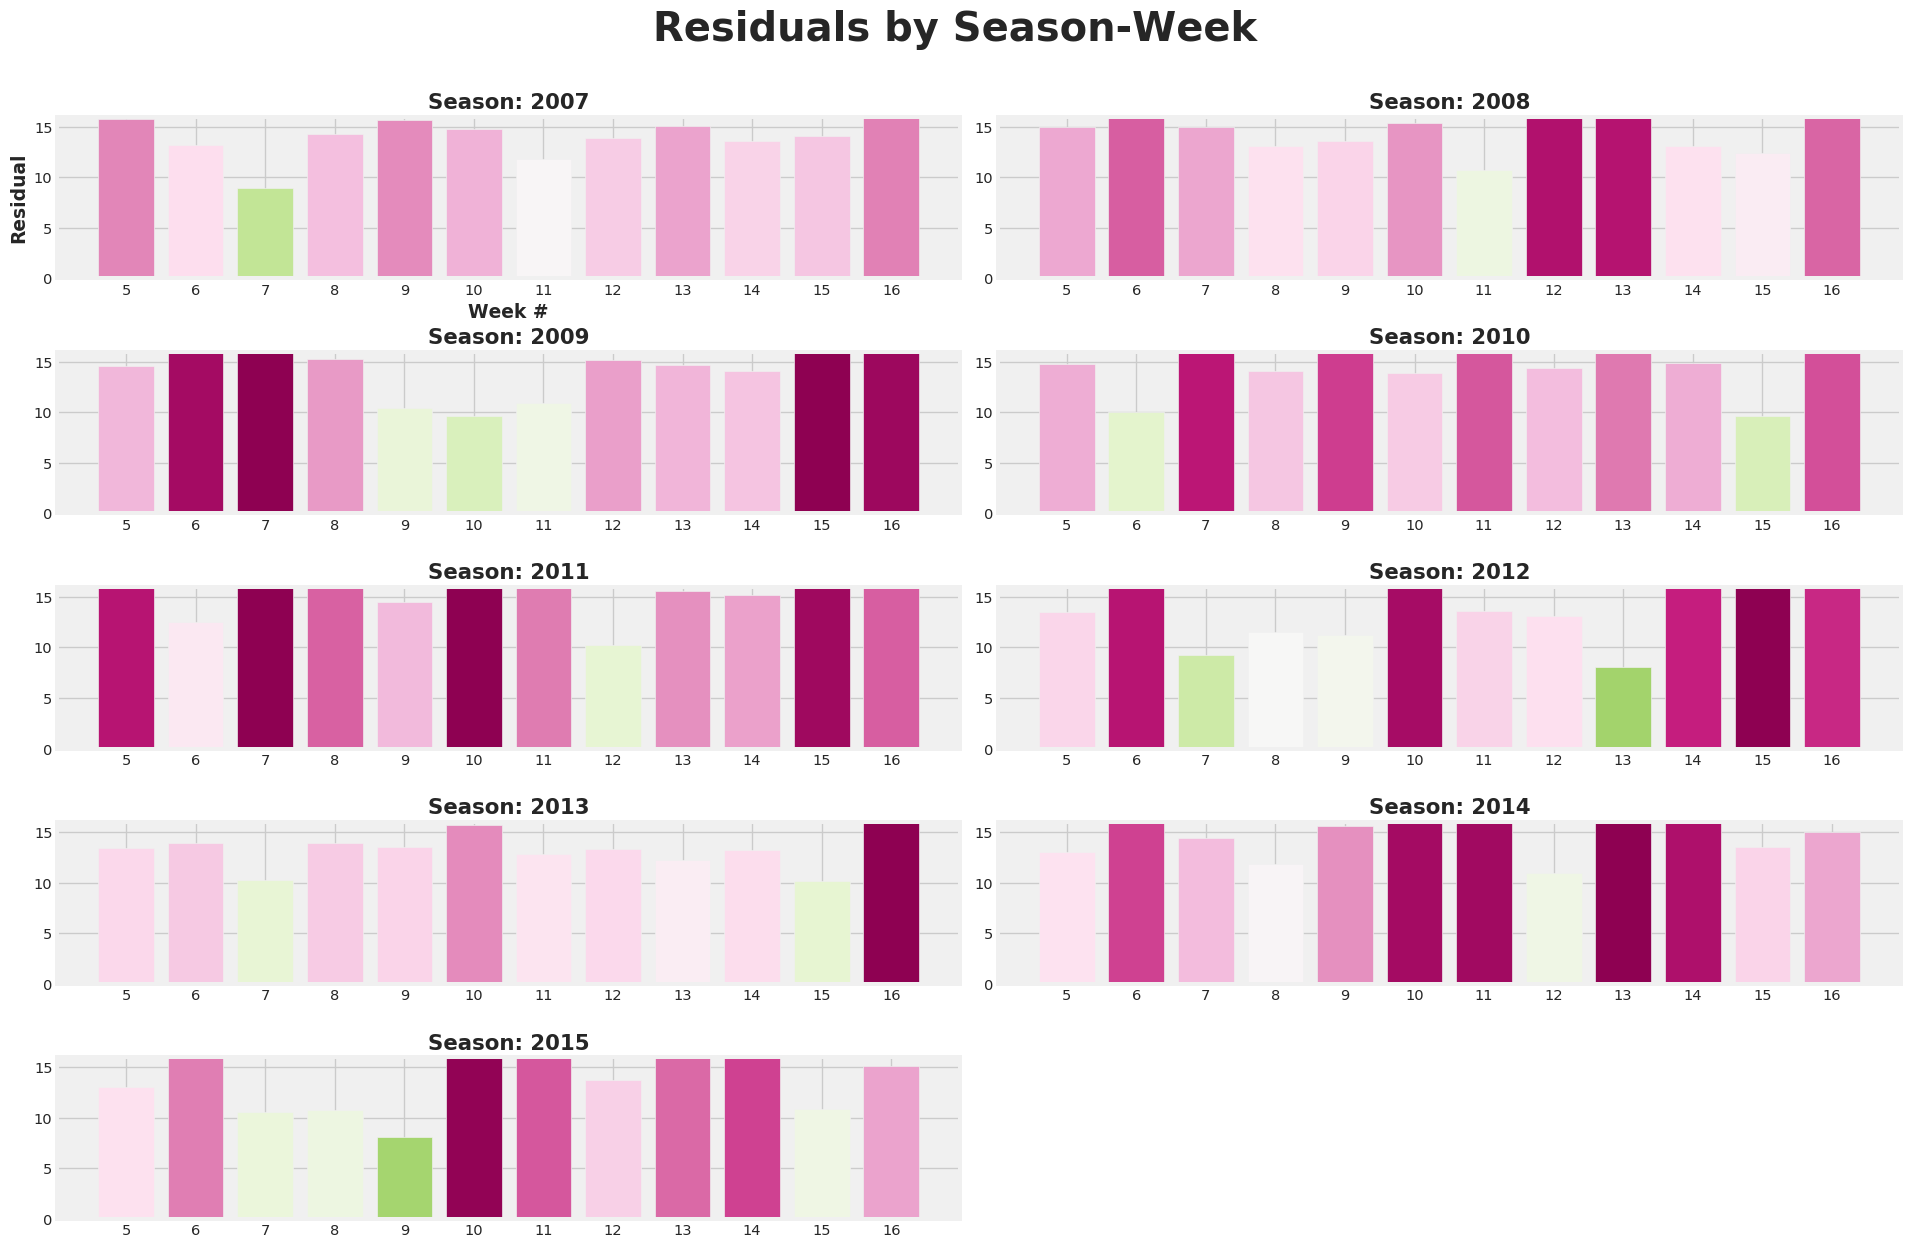

<Figure size 1152x768 with 0 Axes>

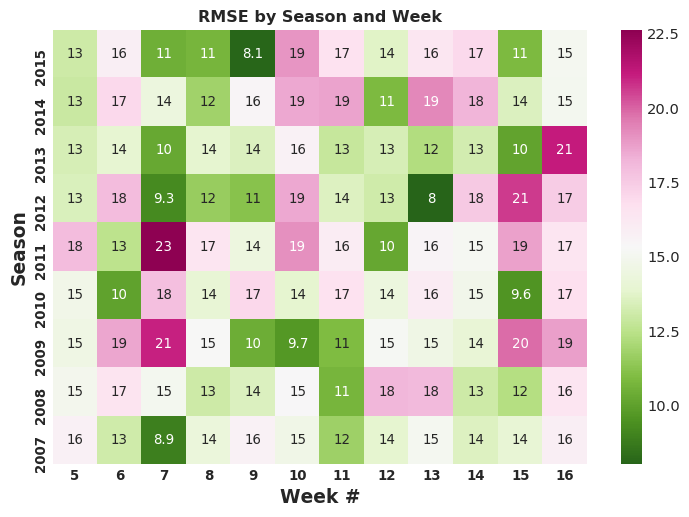

<Figure size 1152x768 with 0 Axes>

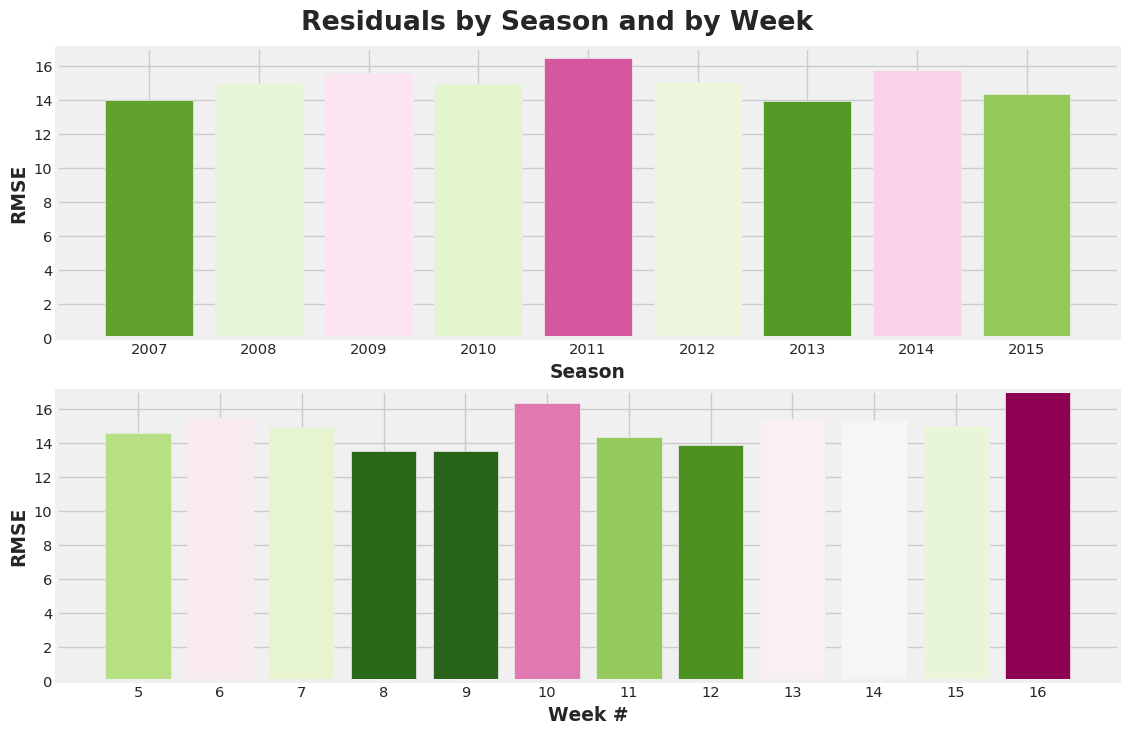

<Figure size 1152x768 with 0 Axes>

<Figure size 2304x2304 with 0 Axes>

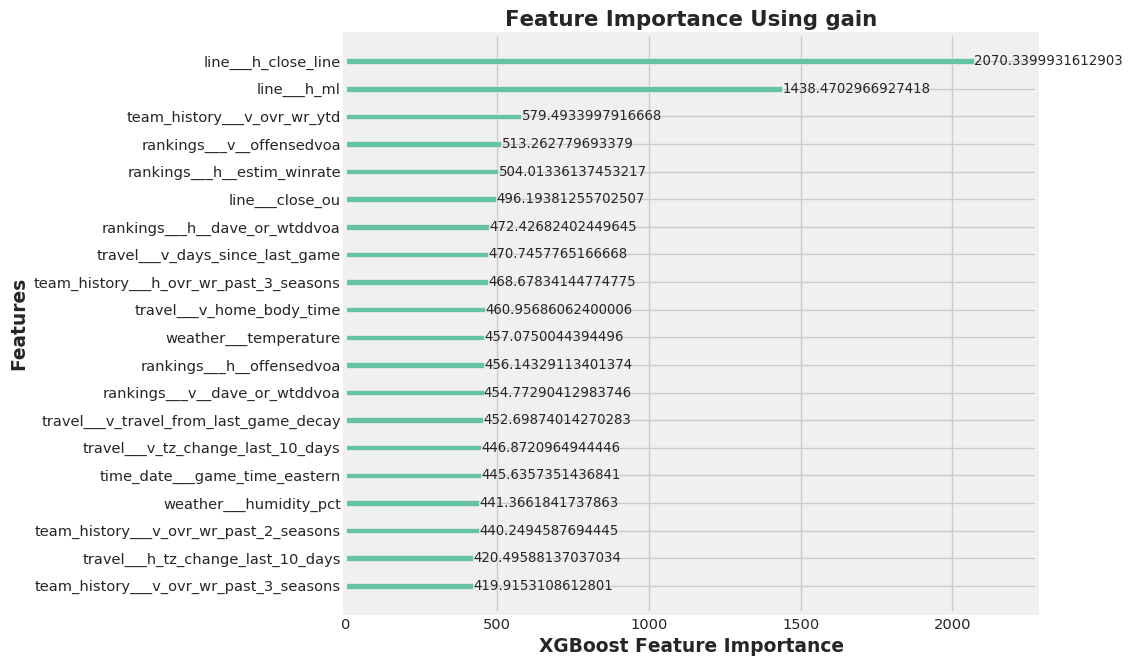

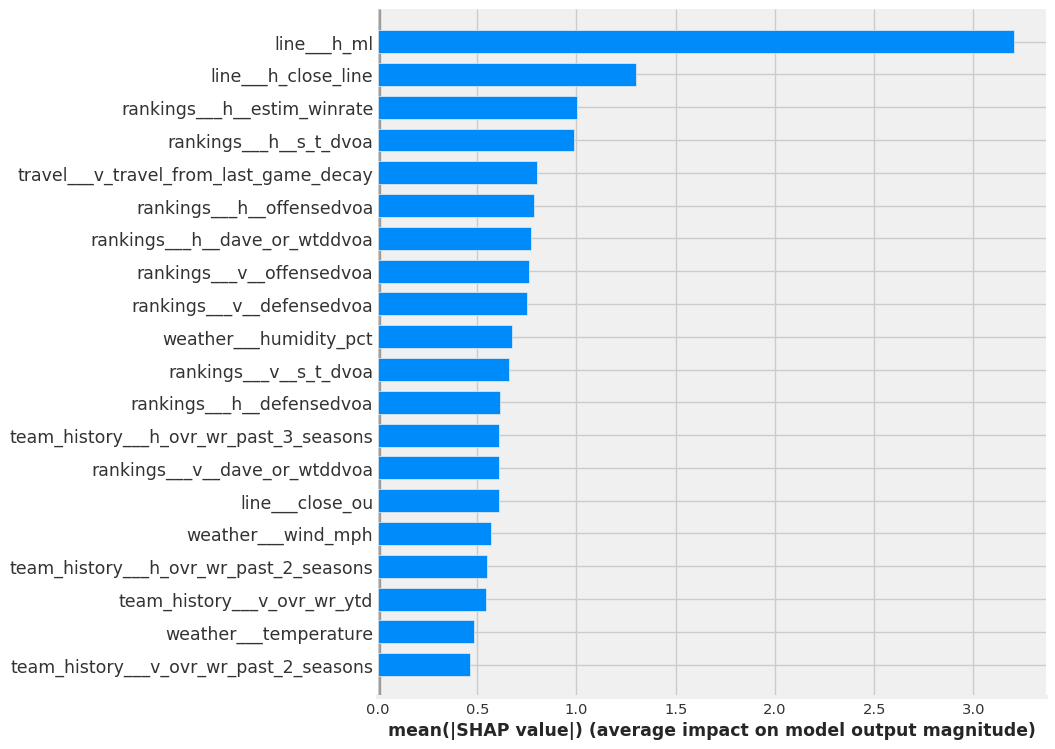

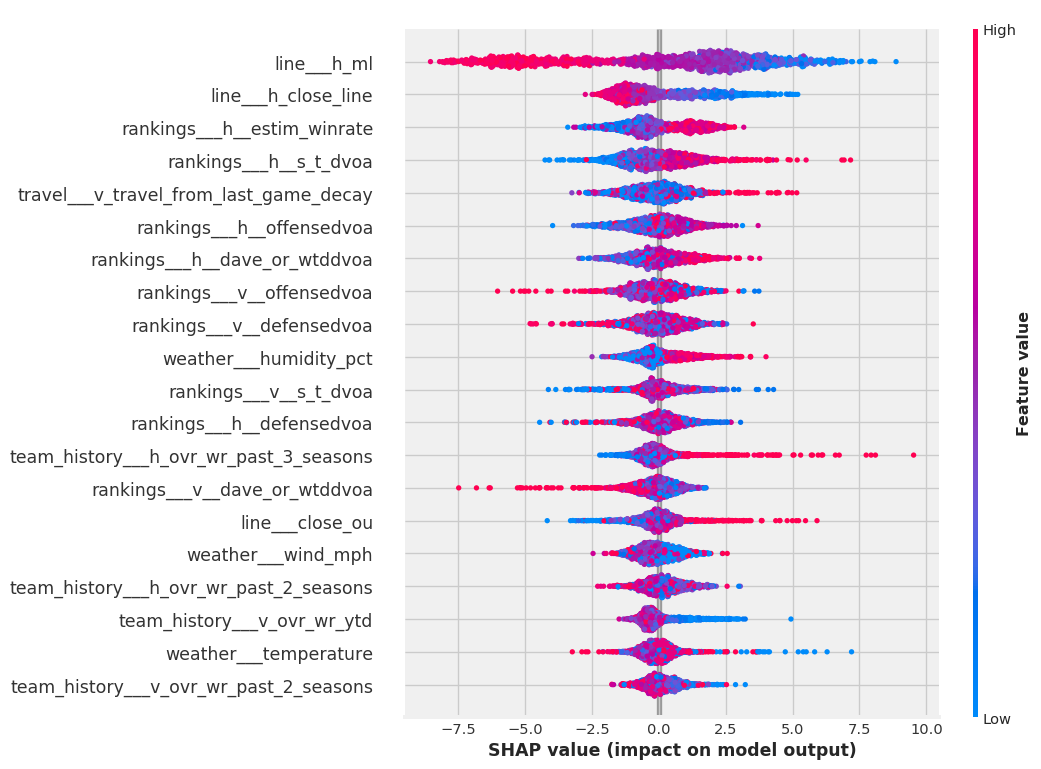

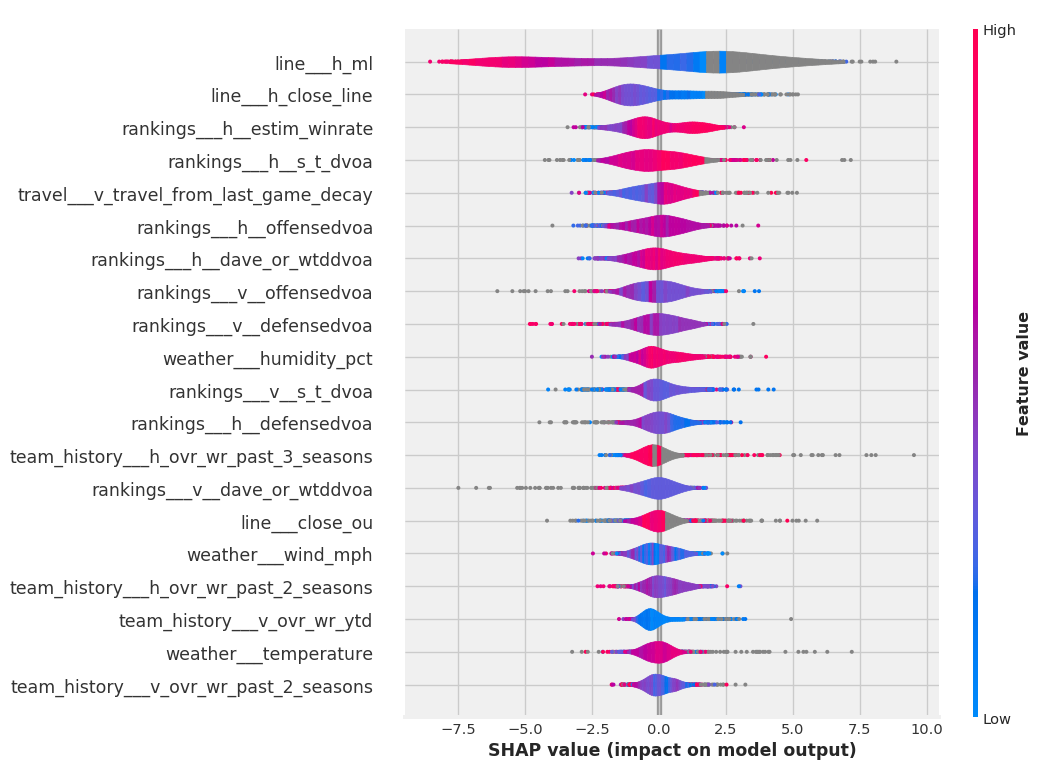

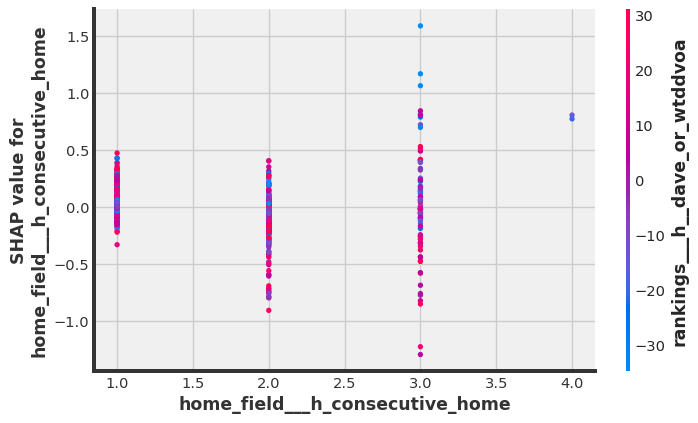

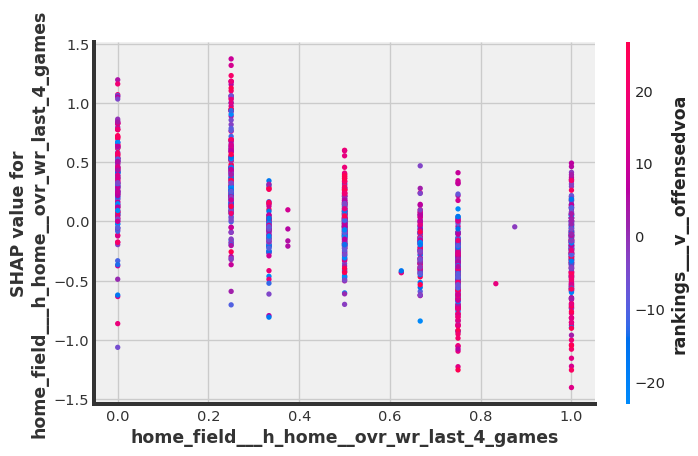

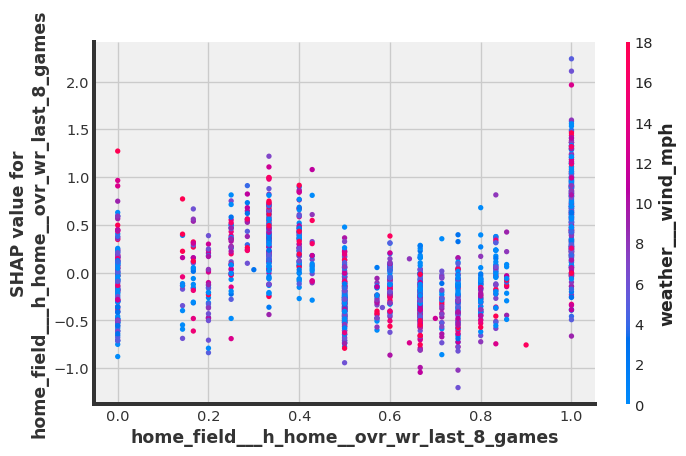

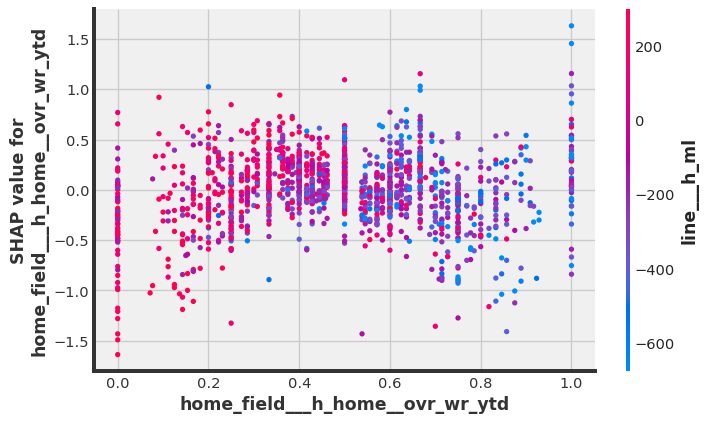

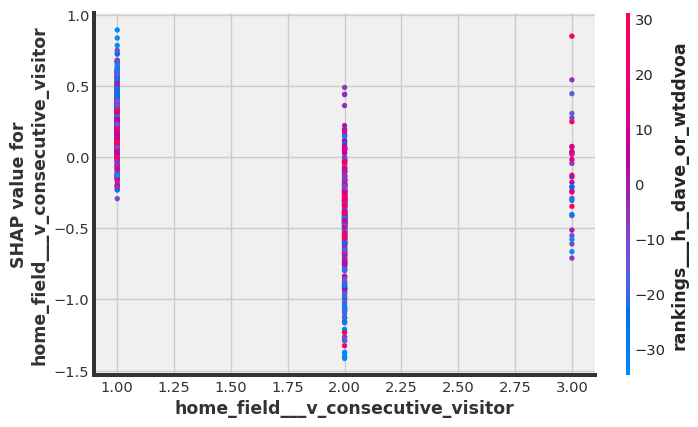

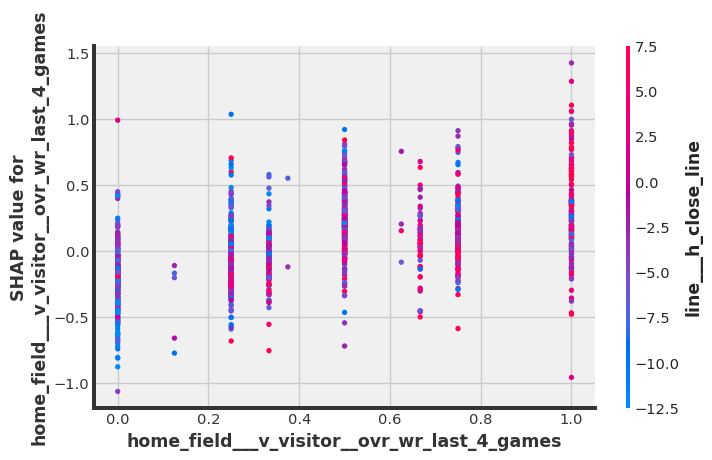

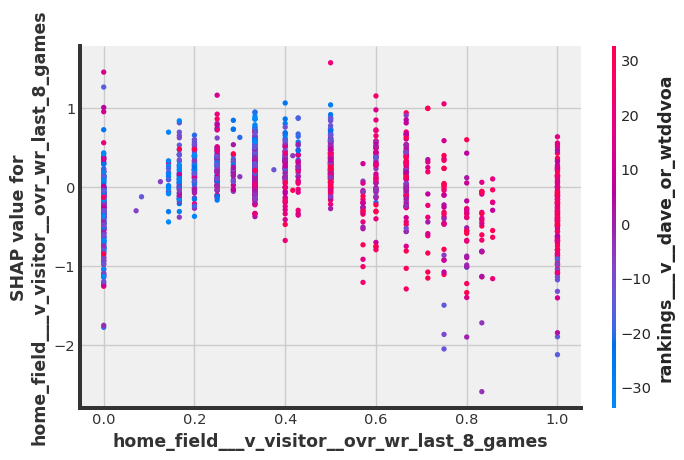

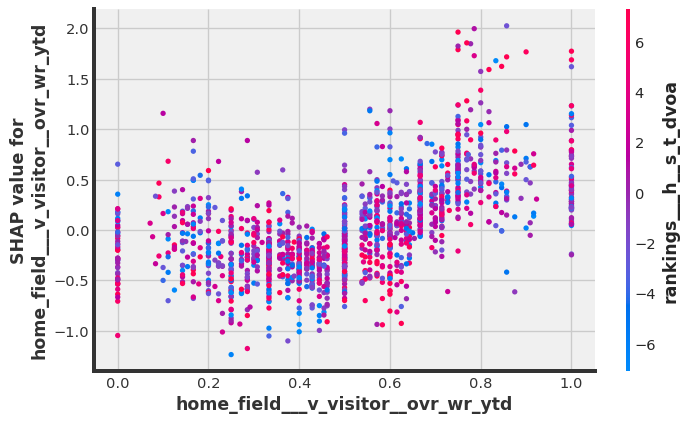

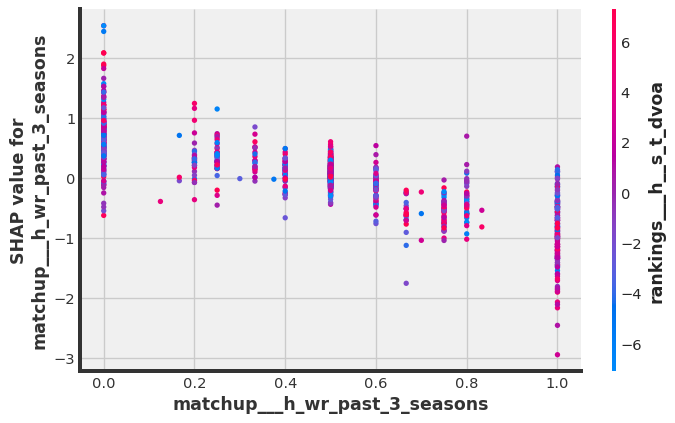

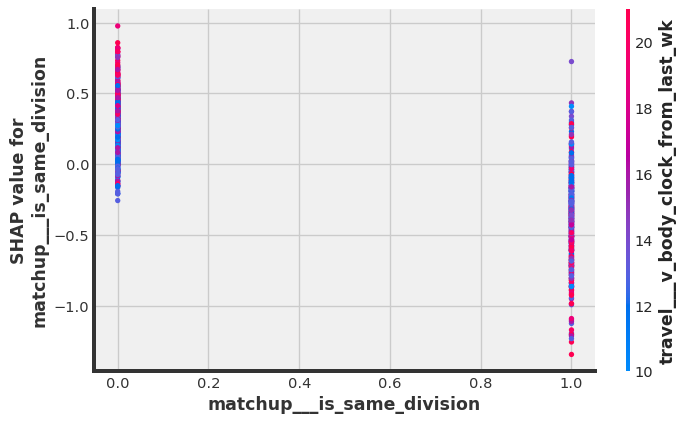

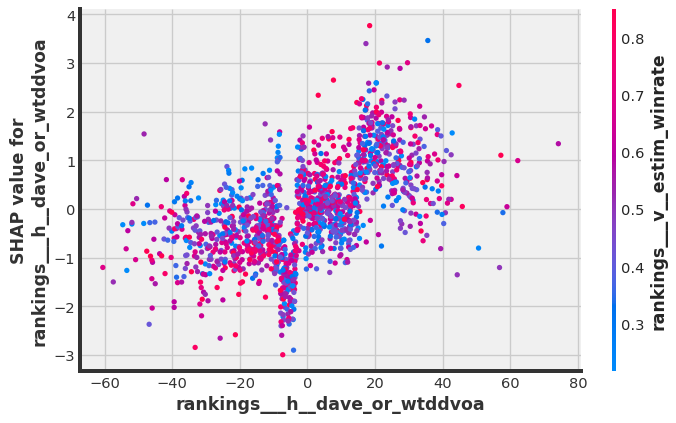

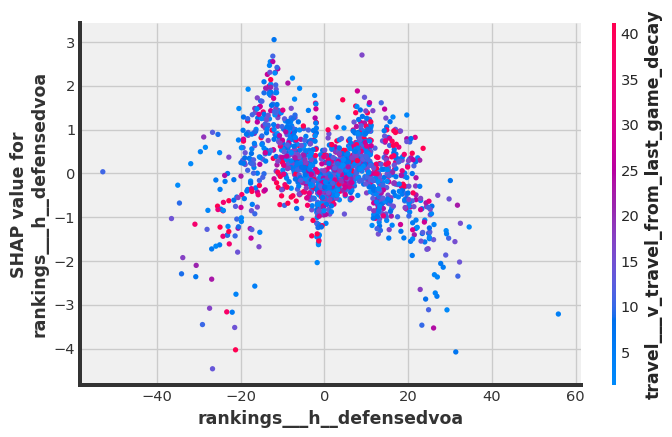

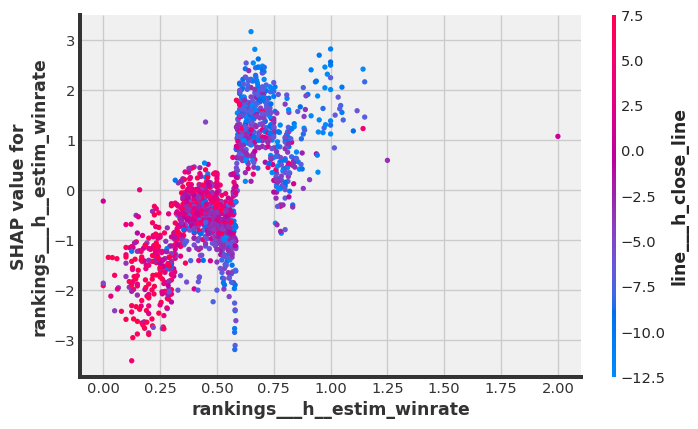

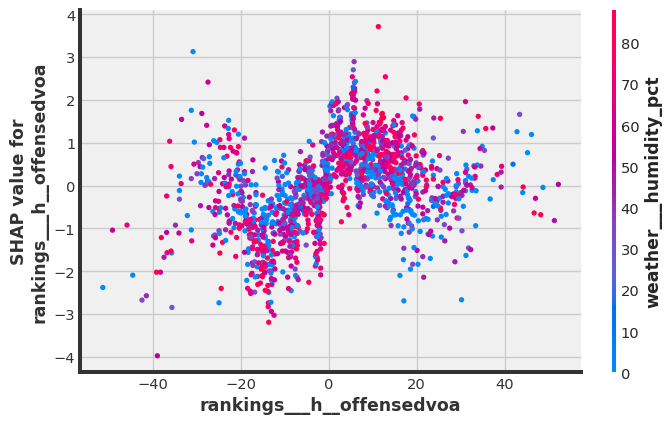

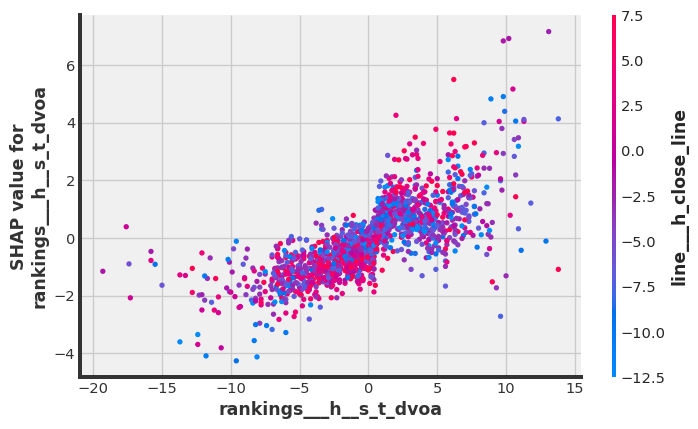

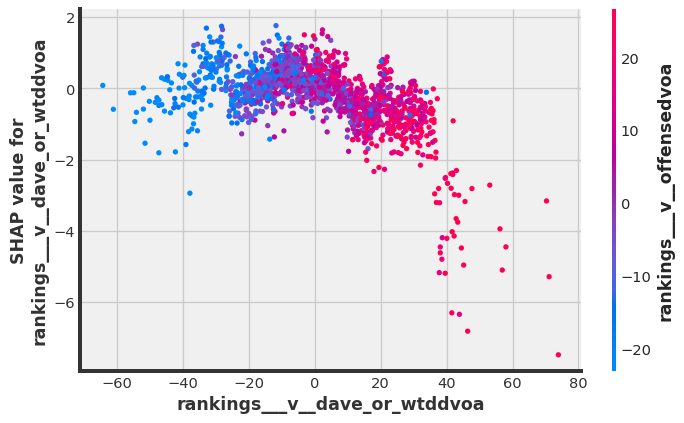

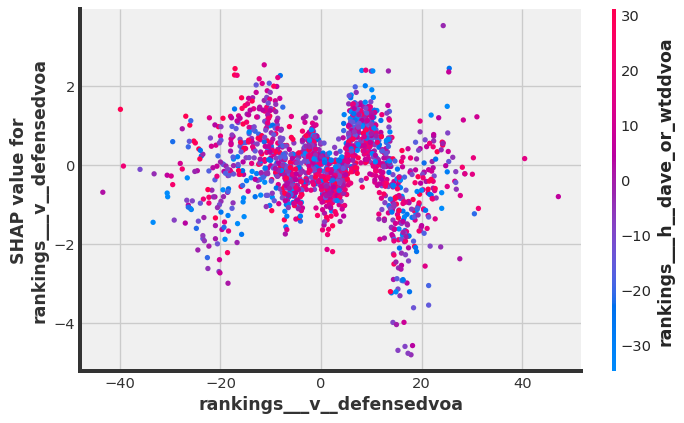

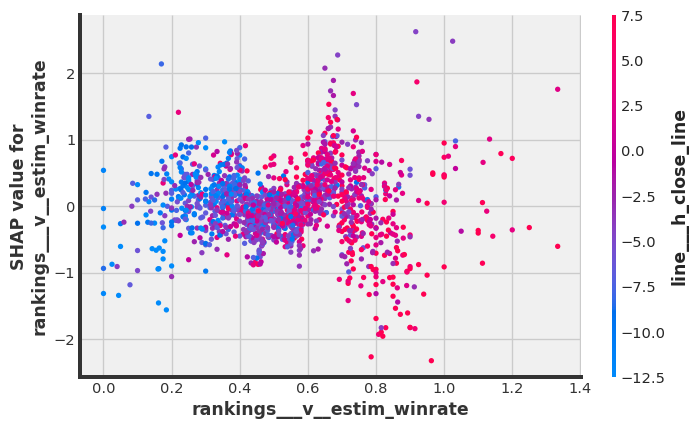

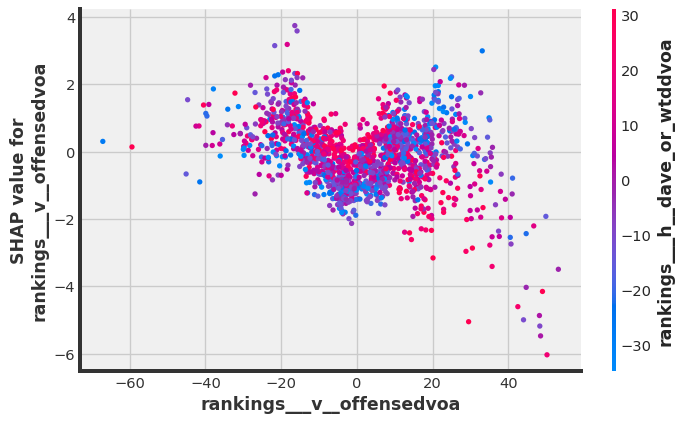

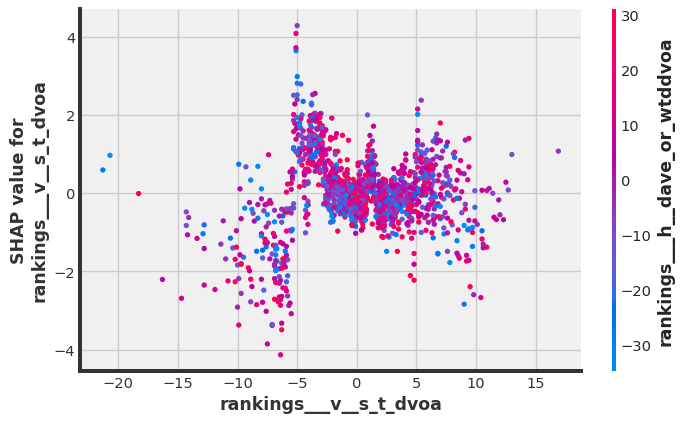

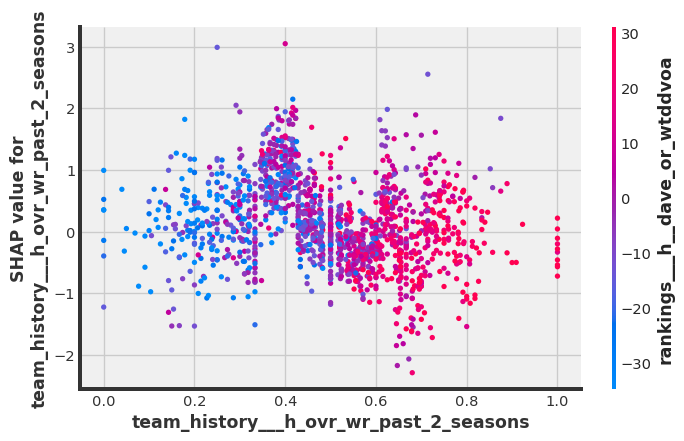

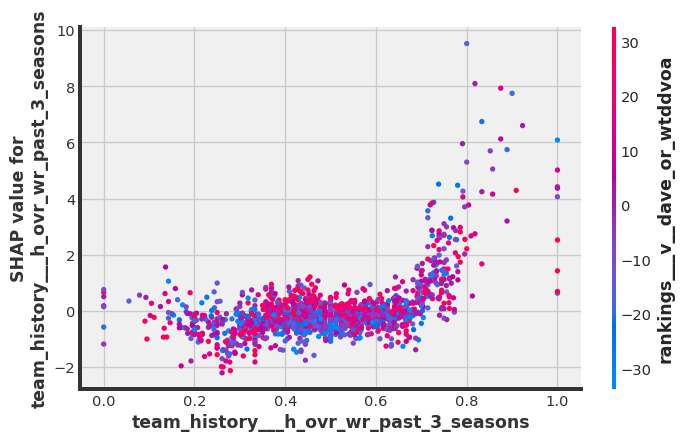

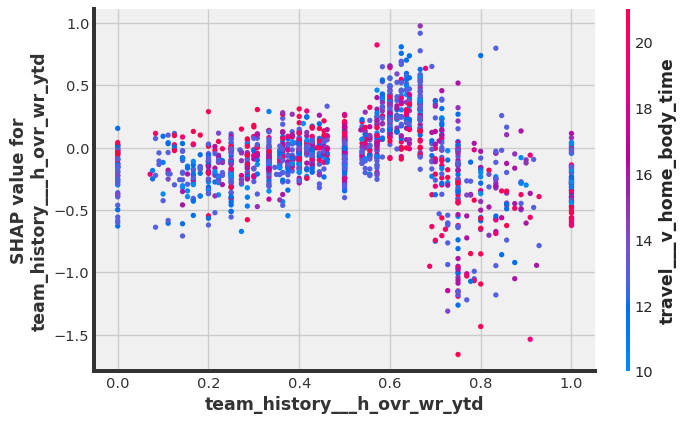

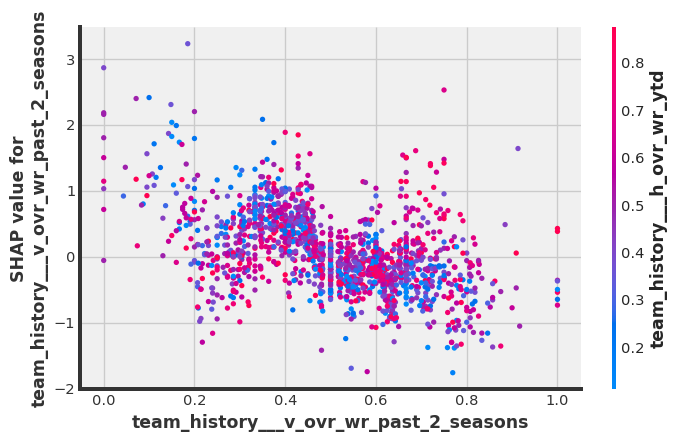

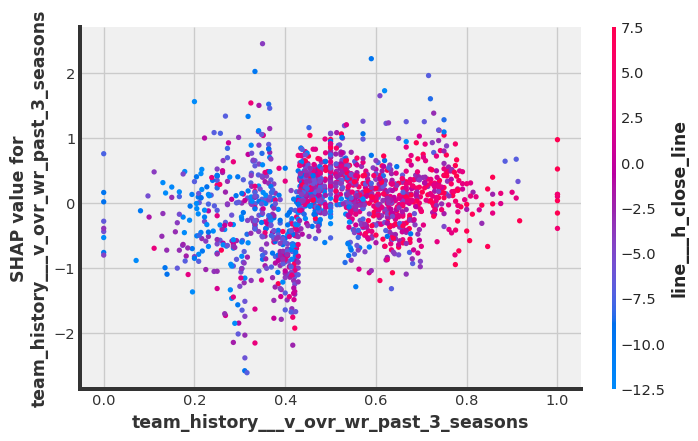

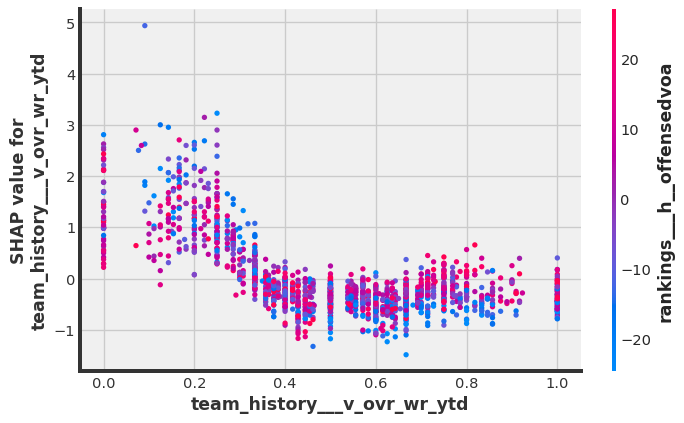

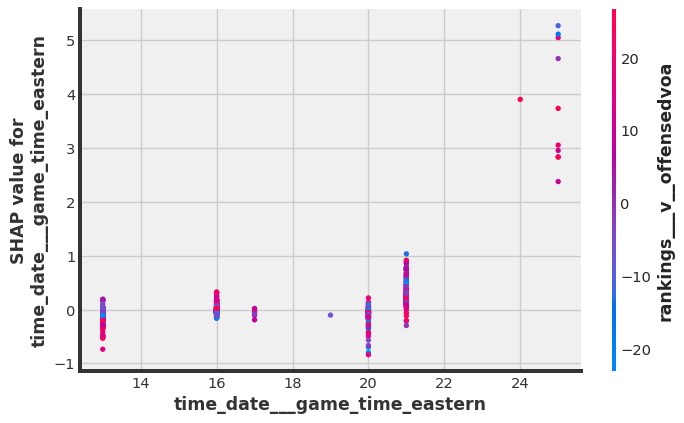

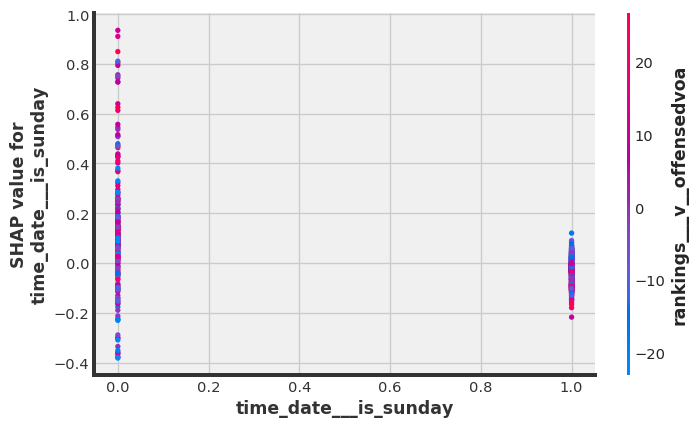

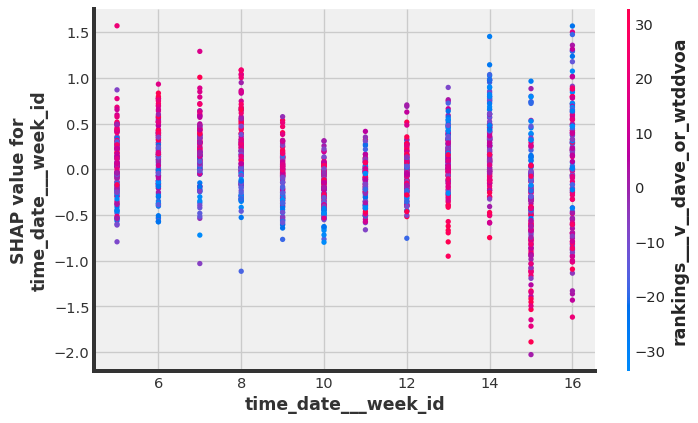

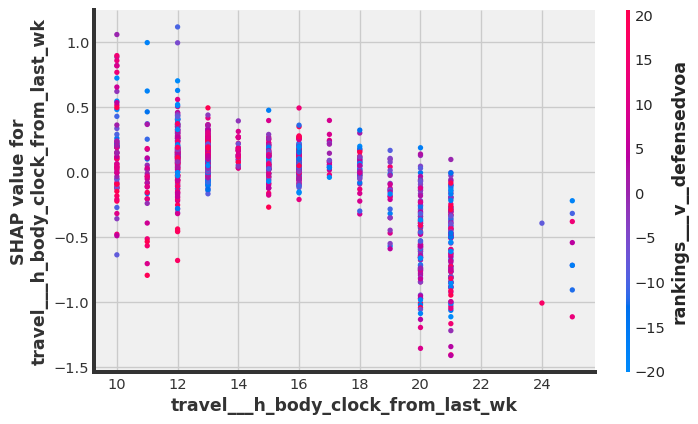

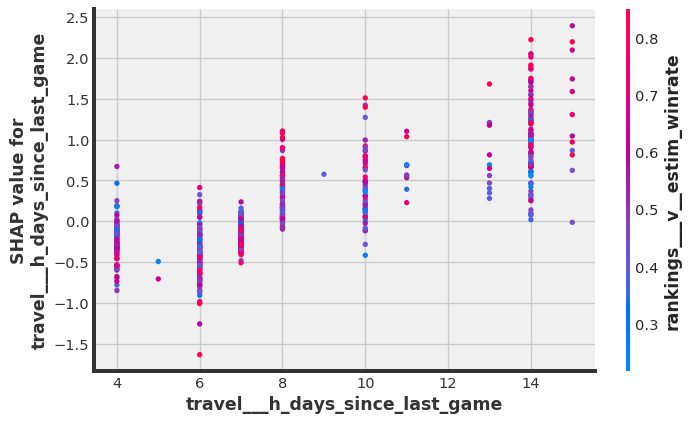

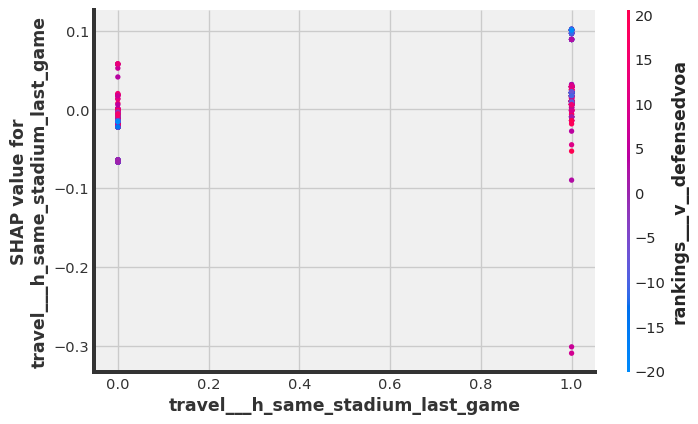

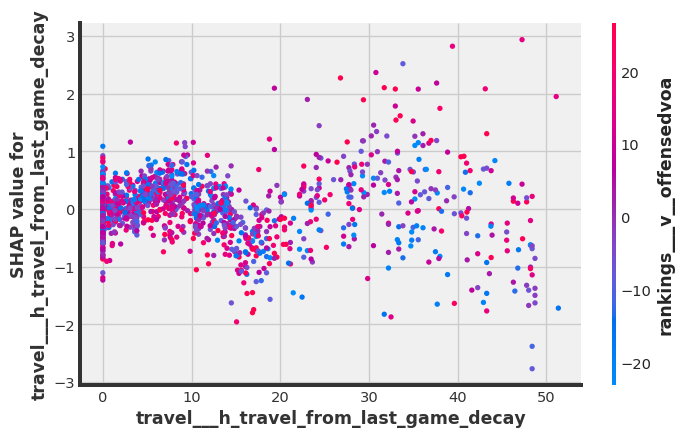

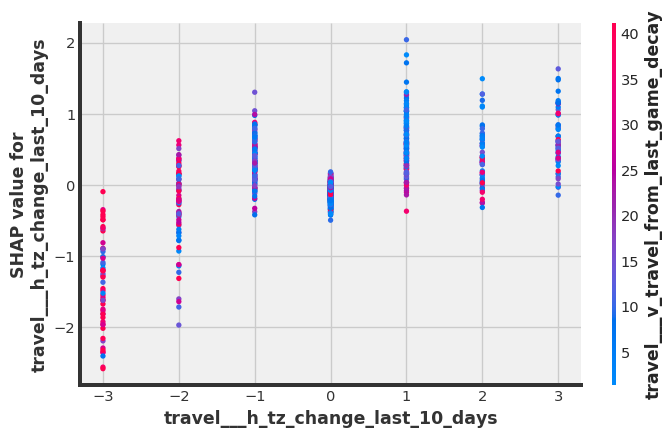

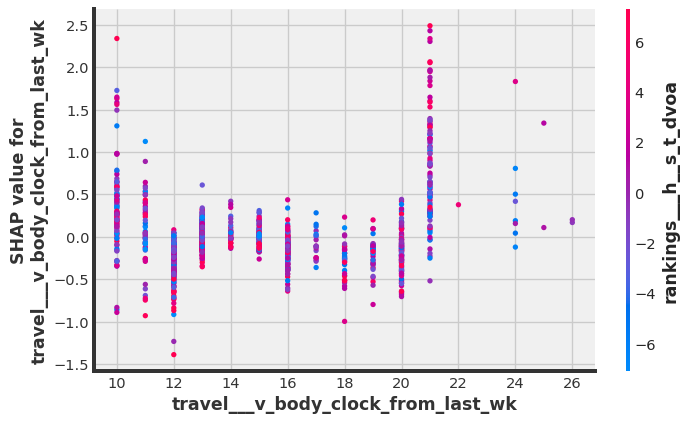

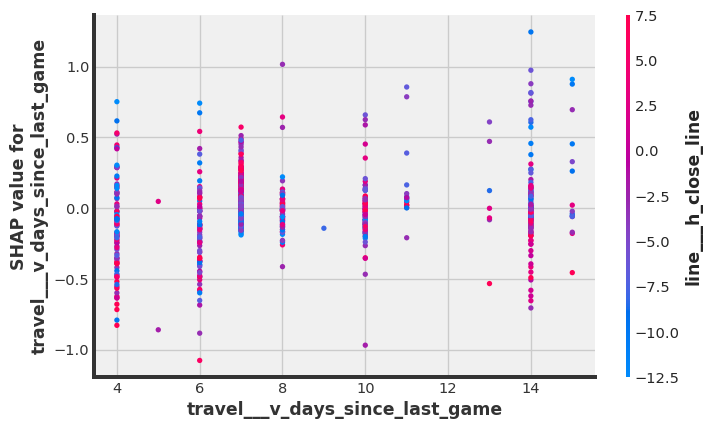

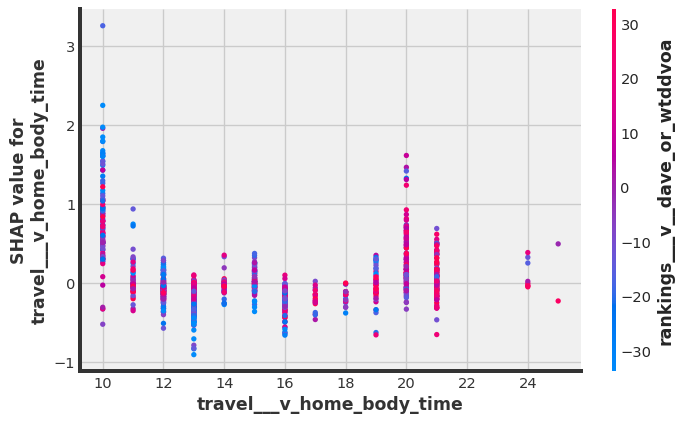

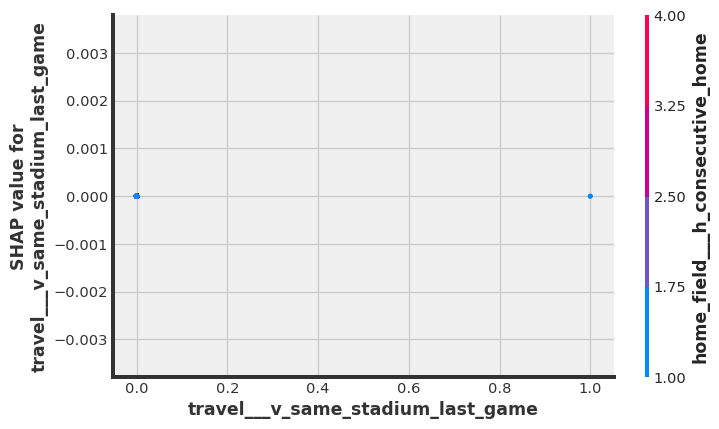

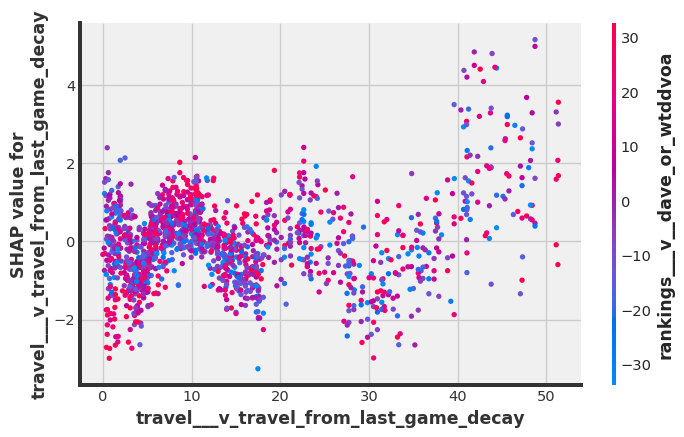

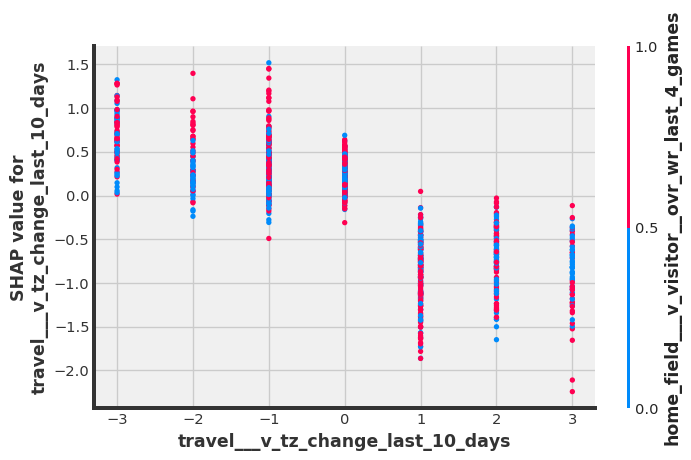

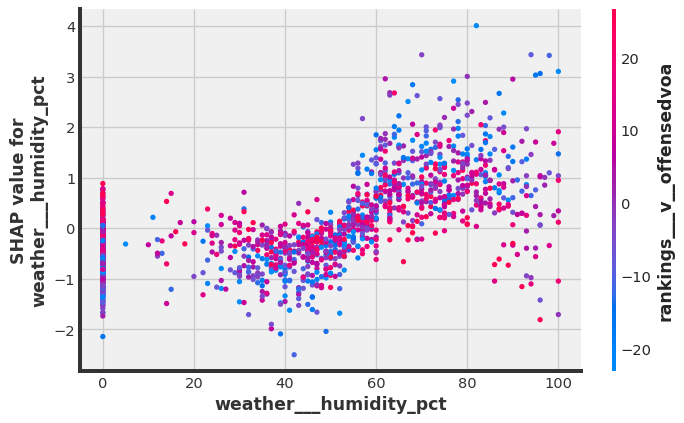

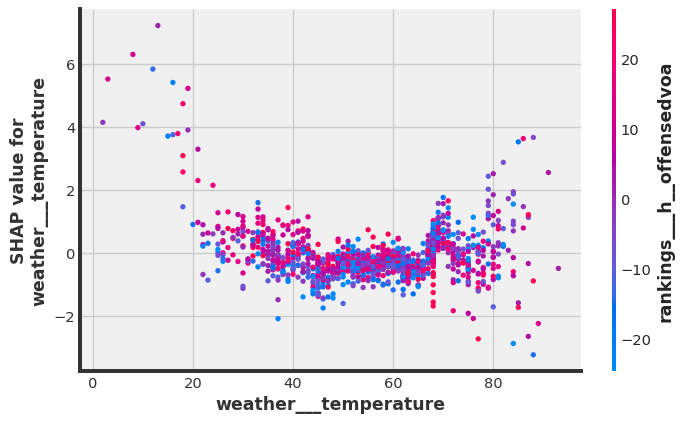

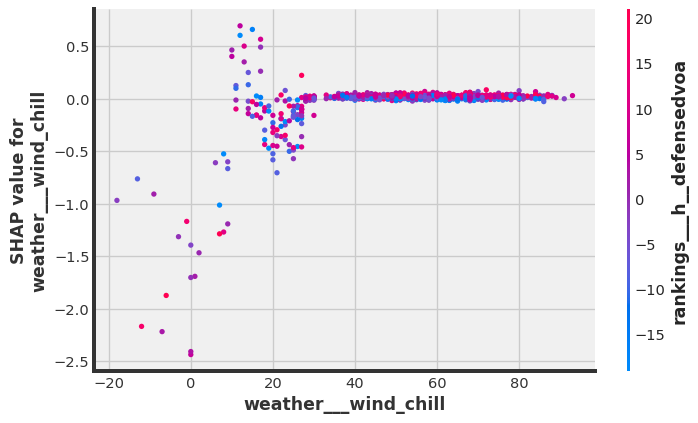

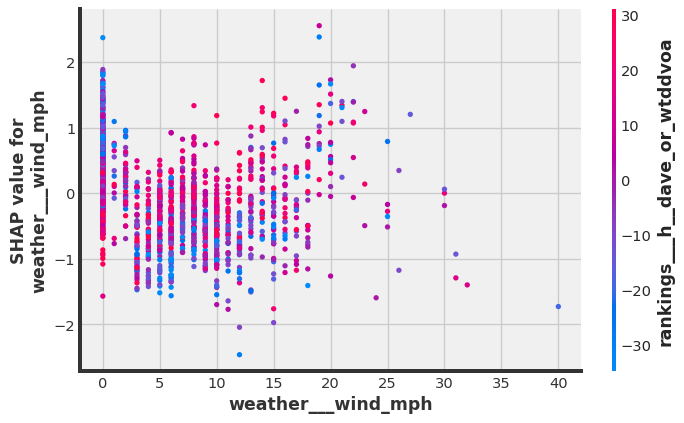

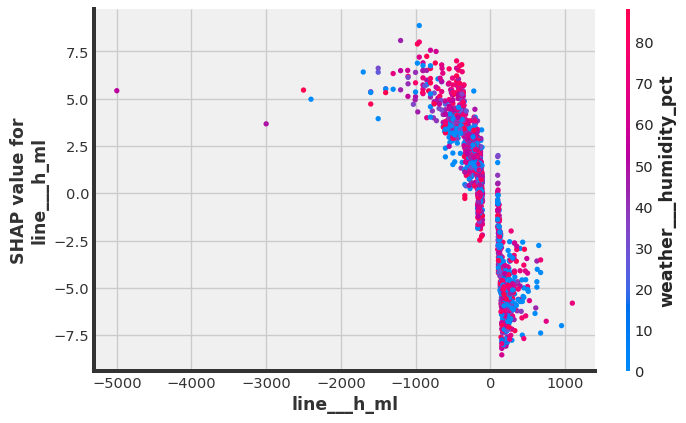

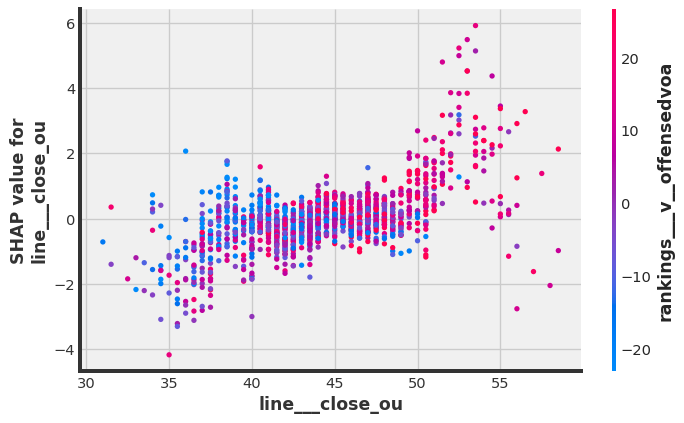

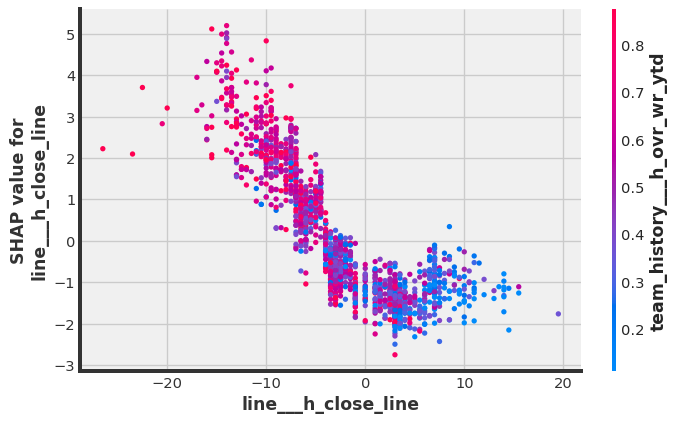

In [160]:
plots_dict['save_plots'] = False
plot = EvaluateAndPlot(plots_dict, model.cv_scores, model.is_classification)

plot.ridge_viz(ridge_df)
mpl.rcParams.update(params_backup)

for metric in plot.plots_dict['threshold_metrics']:
    plot.plot_by_threshold(acc_dfs[metric], metric)

for bin_type in plot.plots_dict['bin_types']:
    for nbins in plot.plots_dict['plot_bins']:
        inputs = (bins_dfs[bin_type][nbins], bin_type, nbins)
        plot.bin_viz(*inputs)
        if bin_type == 'Percentile':
            plot.bin_trend_viz(*inputs)
            
plot.plot_roc_kfold_errband(plot.get_roc_sets())
for col_range in plot.plots_dict['accuracy_at_topn'].keys():
    plot.accuracy_by_topn_viz(acc_topn[col_range], col_range)

plot.distributions_viz(vals)
plot.scatter_viz(scatter)
plot.confusion_matrix_viz(confusion_df)
plot.residuals_by_season_week_bars_viz(mean_residuals, plot_cols=2)
plot.residuals_by_season_week_heatmap_viz(pivot_residuals)
plot.residuals_by_season_week_bars_agg_viz(mean_residuals, residuals)

plot.plot_feature_importances(model.model_objects['full'])

shap.initjs()
plot.plot_shap_feature_importance(model, shap_df)

games = model.cv_scores.index[10]
plot.plot_shap_force_plot(games, model, shap_df)

games = model.cv_scores.index[:10]
plot.plot_shap_force_plot(games, model, shap_df)

plot.plot_shap_dependence(model, shap_df)

stopwatch.add('evaluate: plots-only and displayed in jupyter')

#### SHAP: added some but not all available plots

In [ ]:
# shap_df: model.model_dict, and model.model_objects
# imp: 

In [125]:
shap_df = plot.get_shap_vals(model.model_dict, model.model_objects)

In [164]:
plot.plot_shap_feature_importance(model, shap_df)

In [139]:
games = model.cv_scores.index[10]
plot.plot_shap_force_plot(games, model, shap_df)

In [140]:
games = model.cv_scores.index[:10]
plot.plot_shap_force_plot(games, model, shap_df)

In [154]:
plot.plot_shap_dependence(model, shap_df)

<Figure size 720x480 with 0 Axes>

In [ ]:
stopwatch.write('models/dev/time-stats.csv')

In [130]:
!open {plot.plots_dir}

In [ ]:
!open models/dev

In [ ]:
foo

## Next Steps:

### Bagging -- Ensemble
* bagged feature importance

### Optimization

### Prep Data
* transform labels
* impute
* correlations
* feature interactions, kernel, etc

### "Where do we miss?" in Evaluation??
* week id (done for regression -- do for classification)
* season
* team?
* by spread, ML
* by O/U

### Figure out how to do week 1, older years, etc.
* maybe simpler model that doesn't have things like DVOA... can train on all the data, and use to score week 1

### Figure out what to do about which rows to use, how to do the home vs. visitor... possibly as part of the CleanseData class

### remove autocorrelations from labels, train on that, then re-transform

### Feature importance still possible TODO
* find any other permutation importance?
* LIME
* use the old sklearn feature importance plots to plot the other importances rather than the builtin ones